<a href="https://colab.research.google.com/github/dxda6216/ttron2excel/blob/main/ttron_data_file_to_excel_file_and_data_smoothing_by_moving_average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving TRACES.800 to TRACES.800

Reading the data...
      Hours      00   01     02    03    04     05     06    07    08  ...  \
0      1.50  294250  111   1186   417   621   3460  16164   799  2017  ...   
1      1.92  378804  240   2186   612   903   6278  31148  1262  2578  ...   
2      2.35  450069  233   3071   695   835   9637  38870  1393  2433  ...   
3      2.77  548684  278   4387   954  1060  11199  34329  1553  3320  ...   
4      3.20  561989  299   5917   827  1113  14094  49280  1581  3541  ...   
..      ...     ...  ...    ...   ...   ...    ...    ...   ...   ...  ...   
392  167.43  463060  272  17679  2446  3348   8226  22351  4003  4348  ...   
393  167.85  461943  211  15790  2444  3276   7570  20559  4121  4122  ...   
394  168.28  460740  246  13534  2604  3352   6800  18439  3869  4708  ...   
395  168.70  521854  317  15207  2943  3837   7493  18566  4003  4171  ...   
396  169.13  464651  238  10909  2284  3060   5435  15317  4253  4323  ...   

        20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

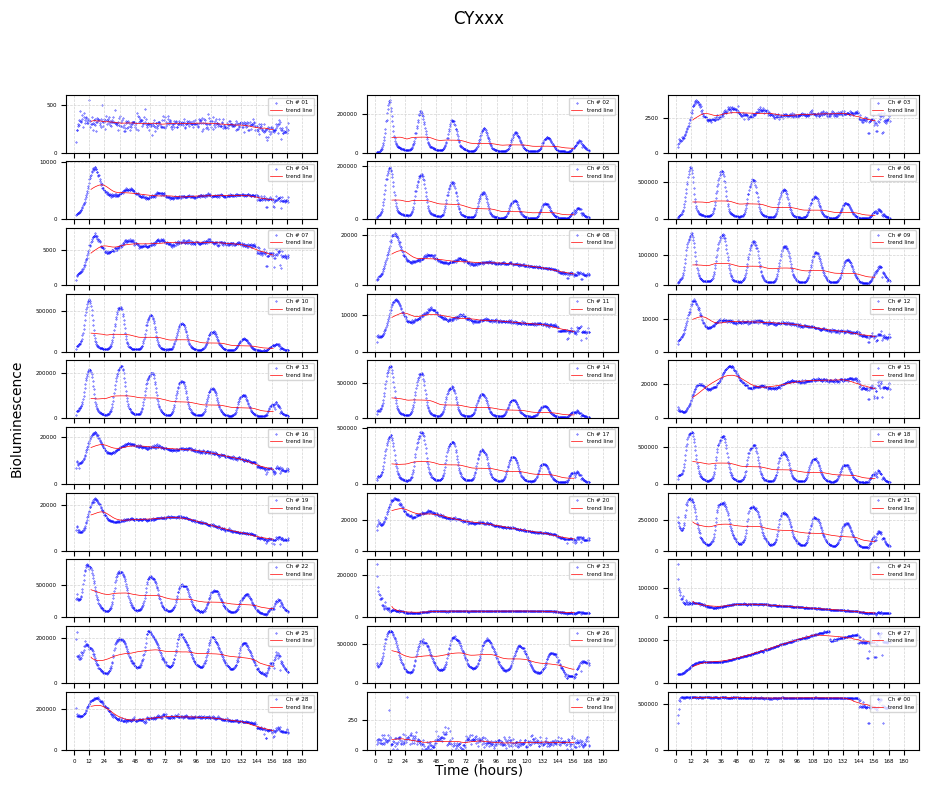

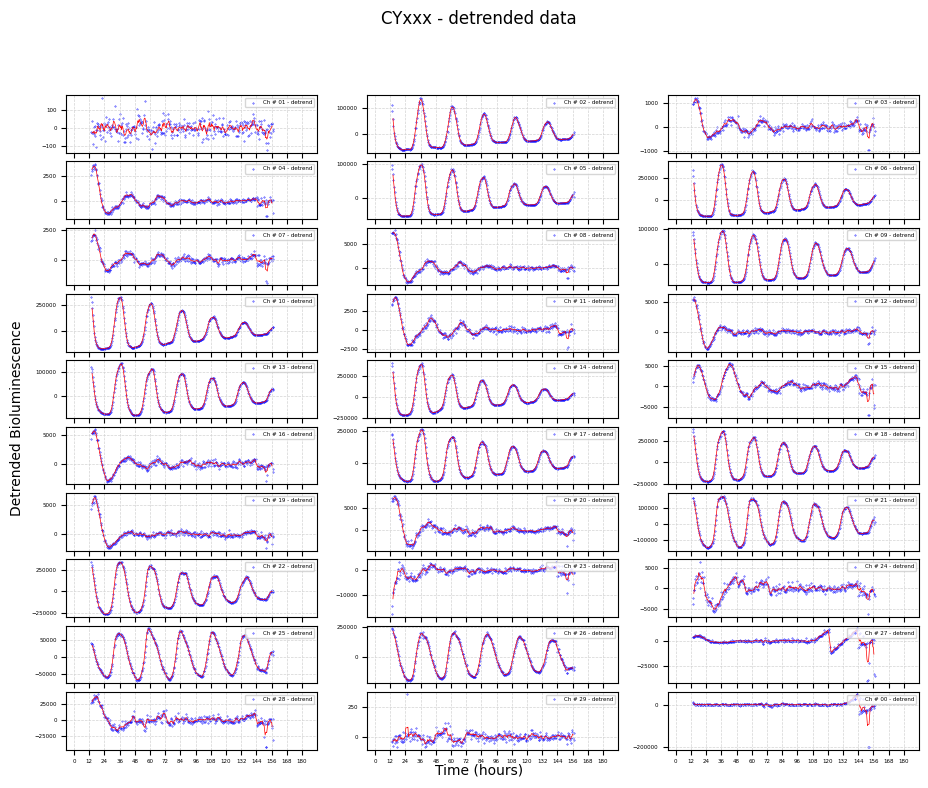

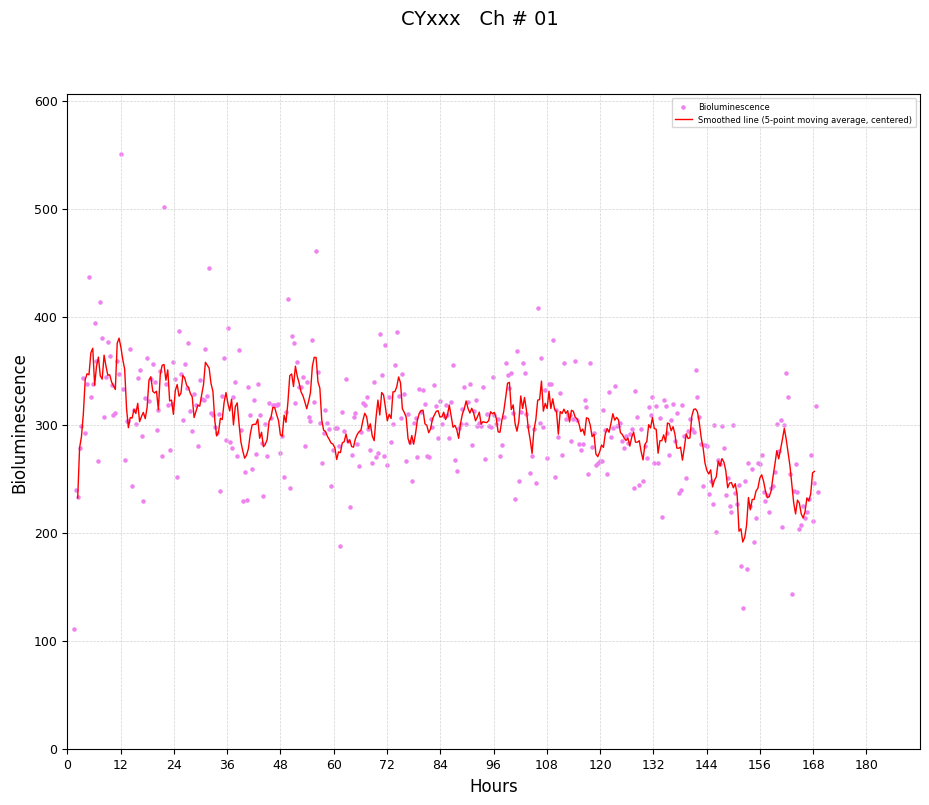

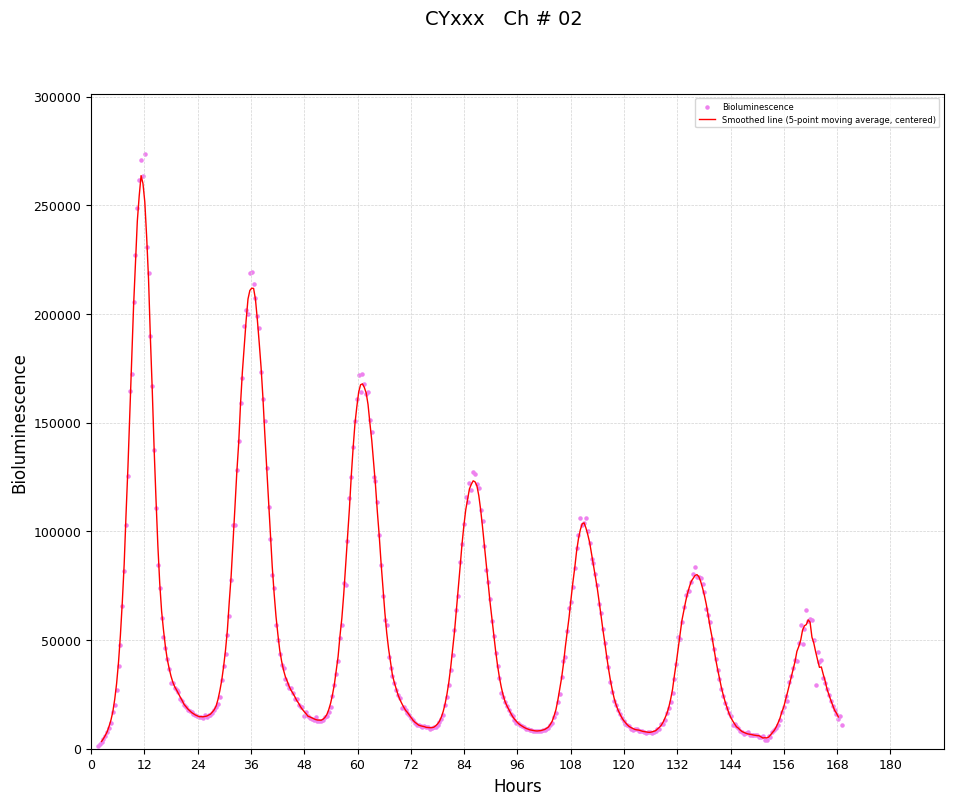

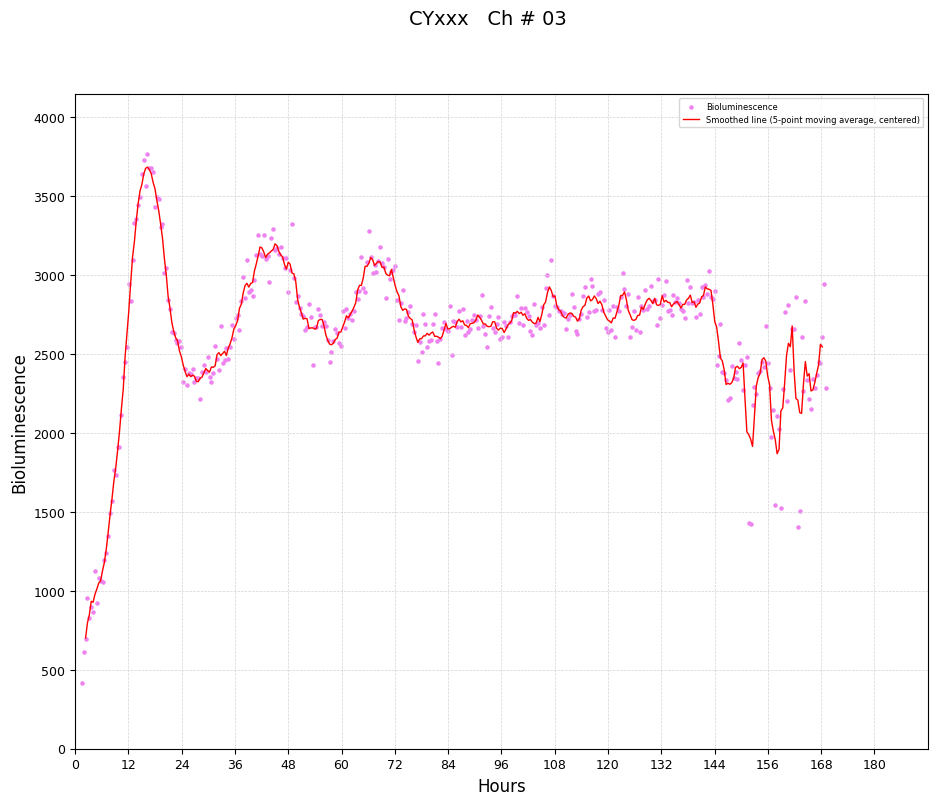

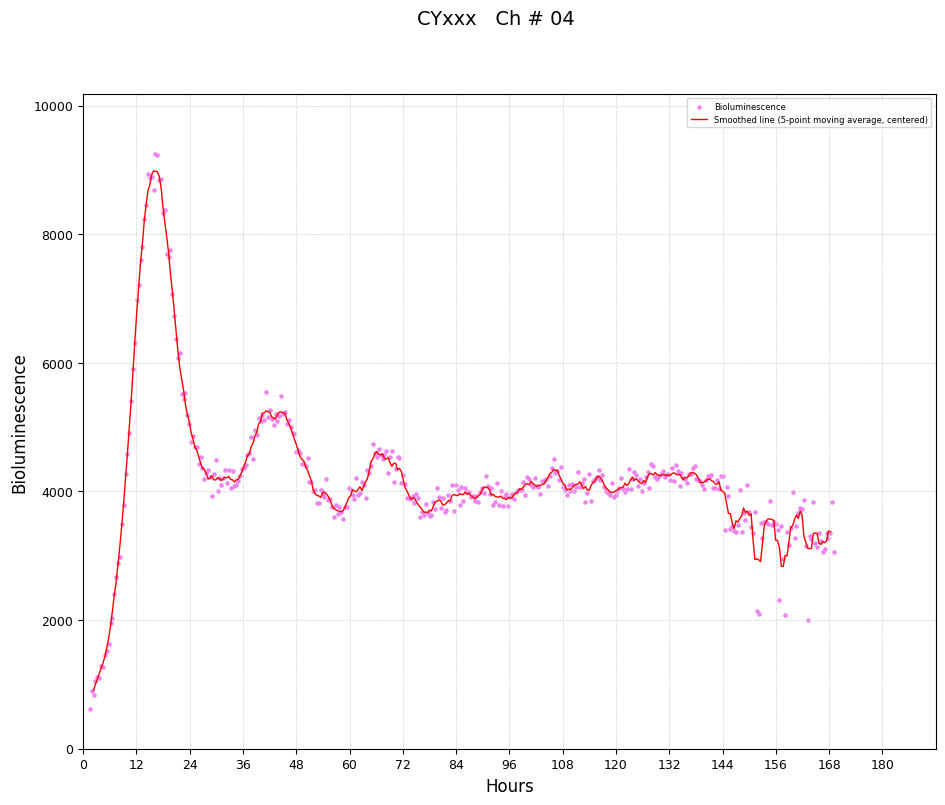

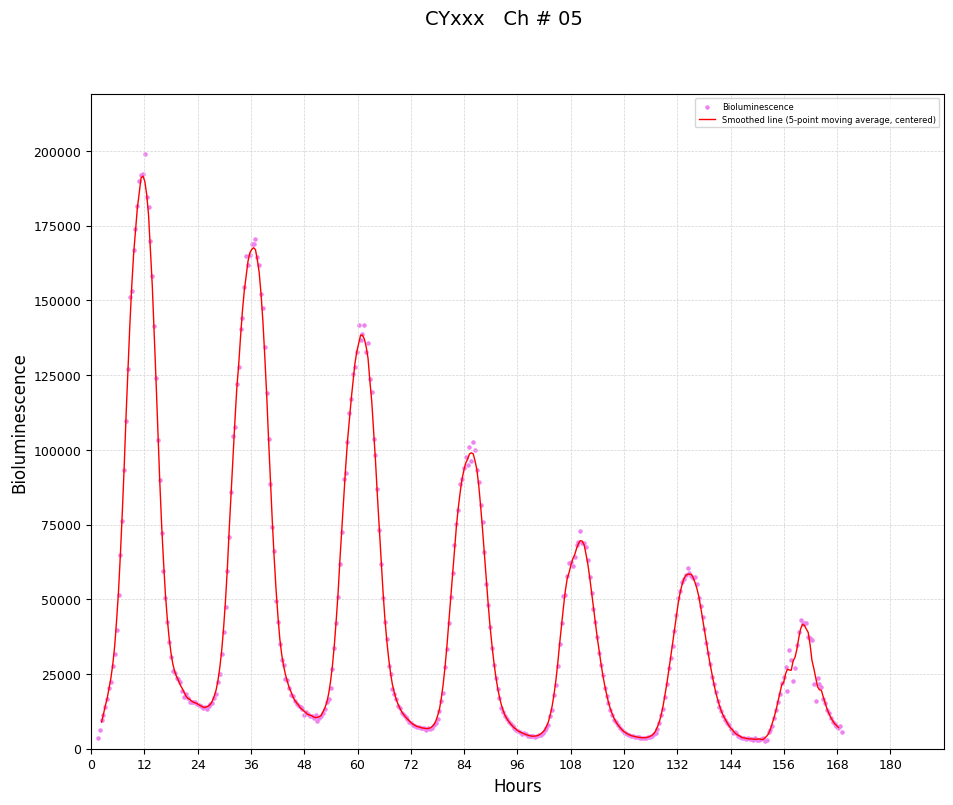

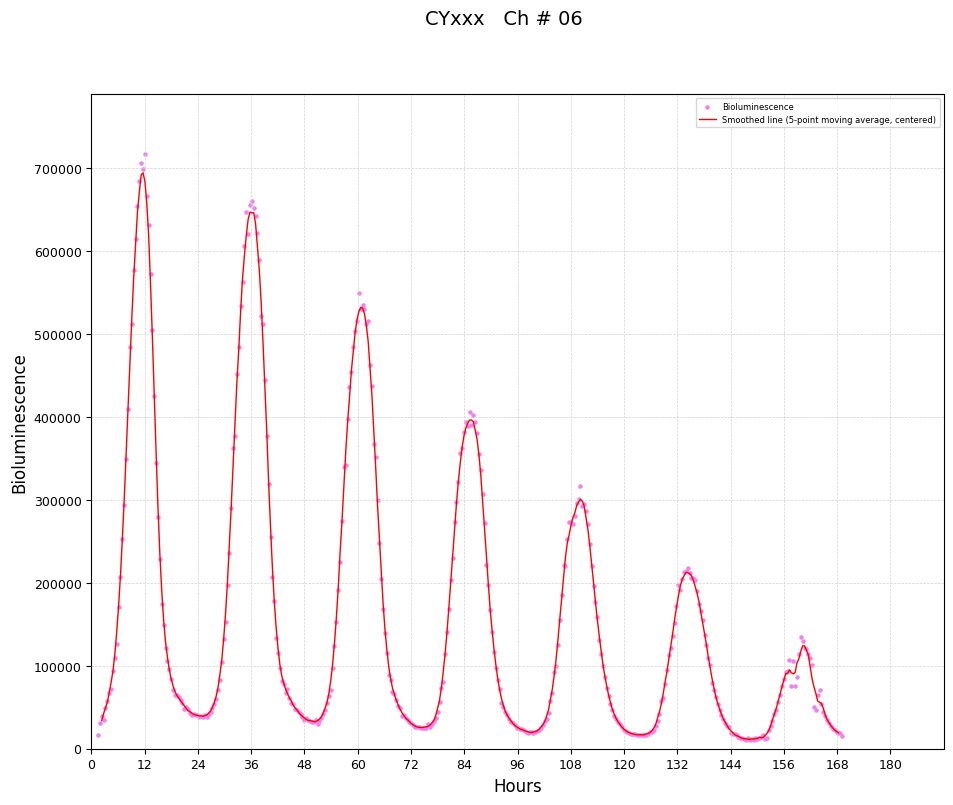

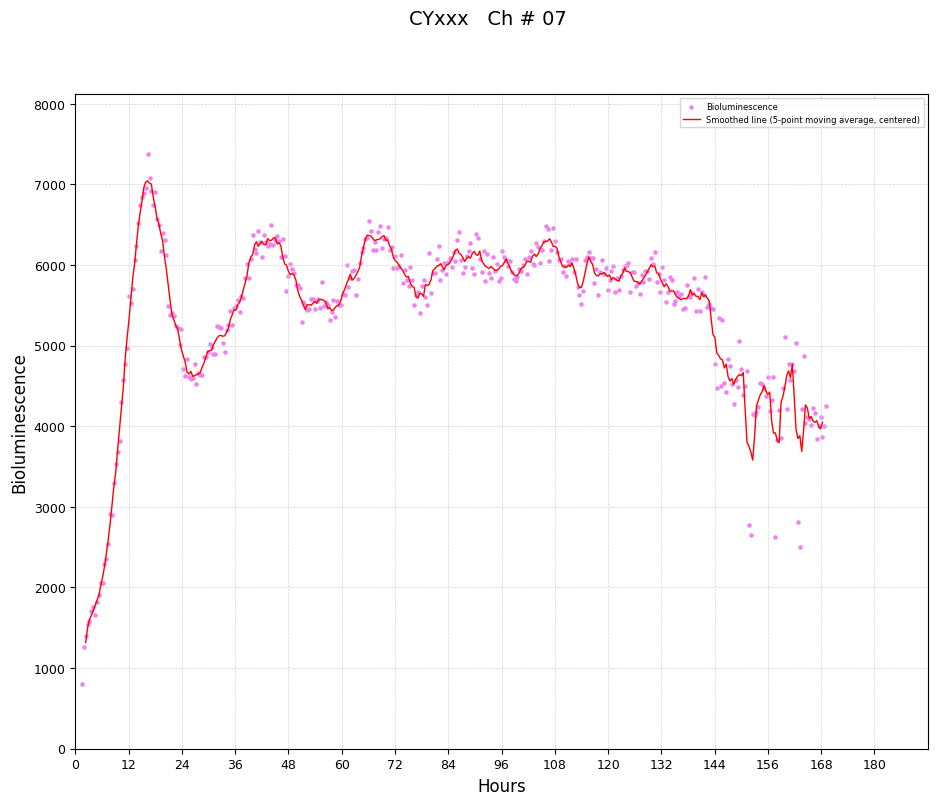

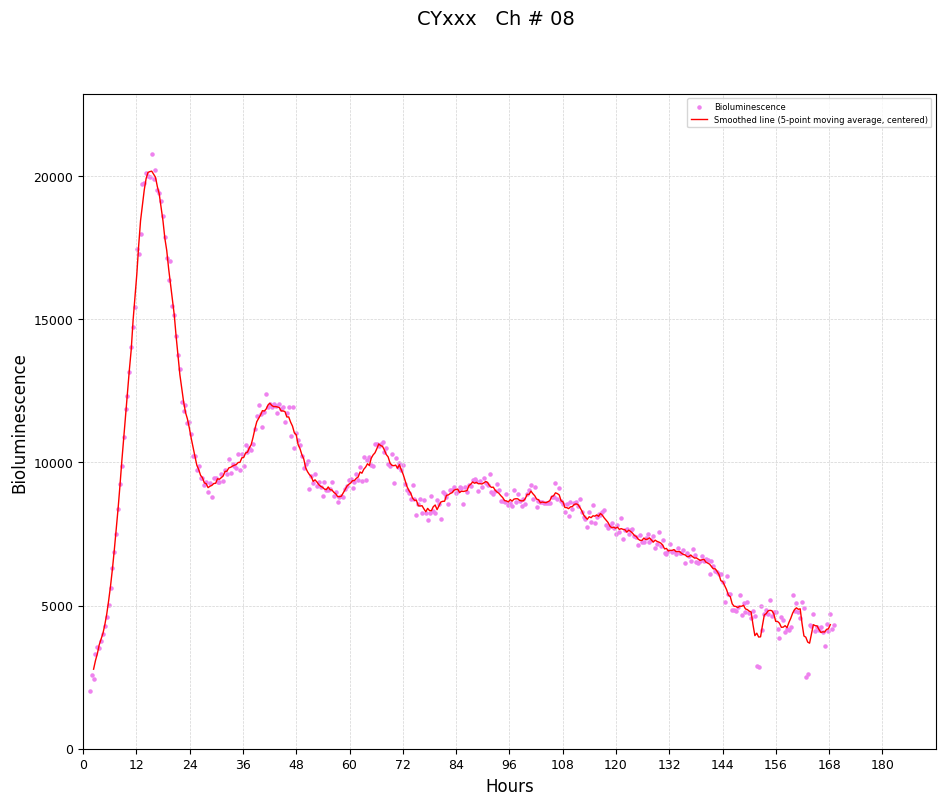

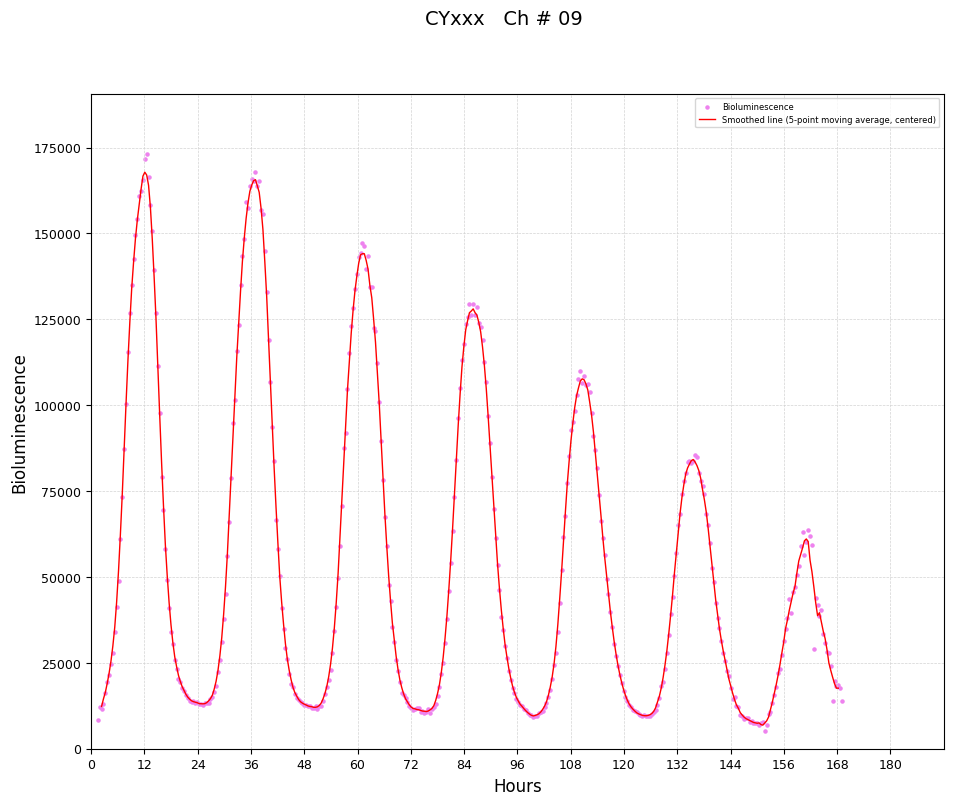

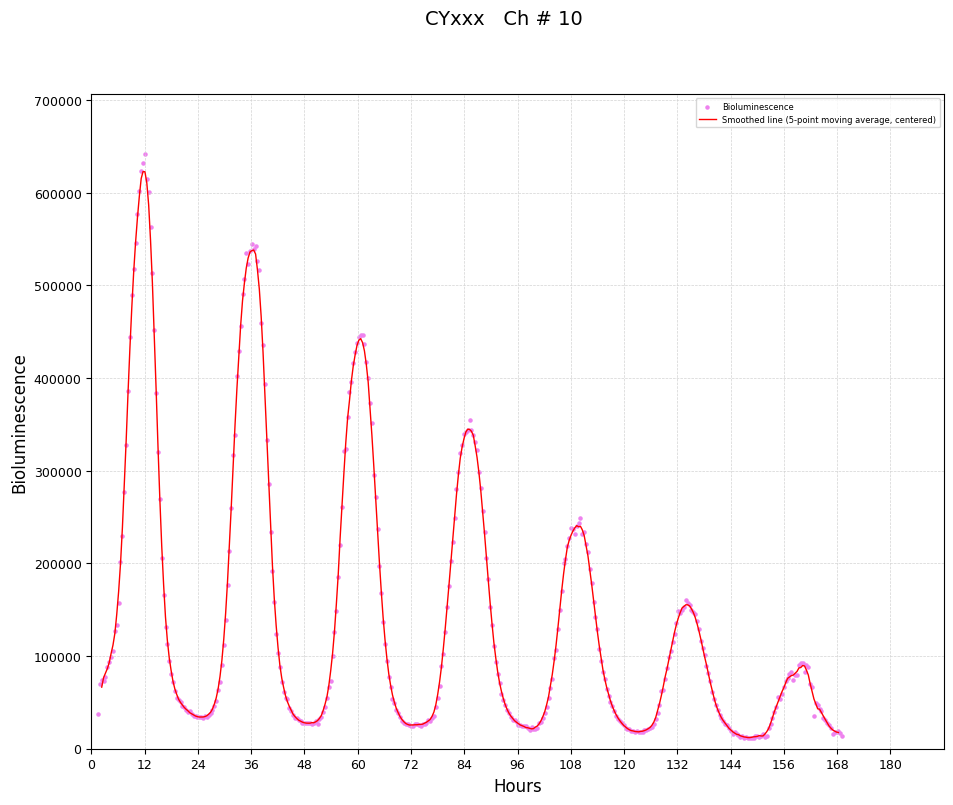

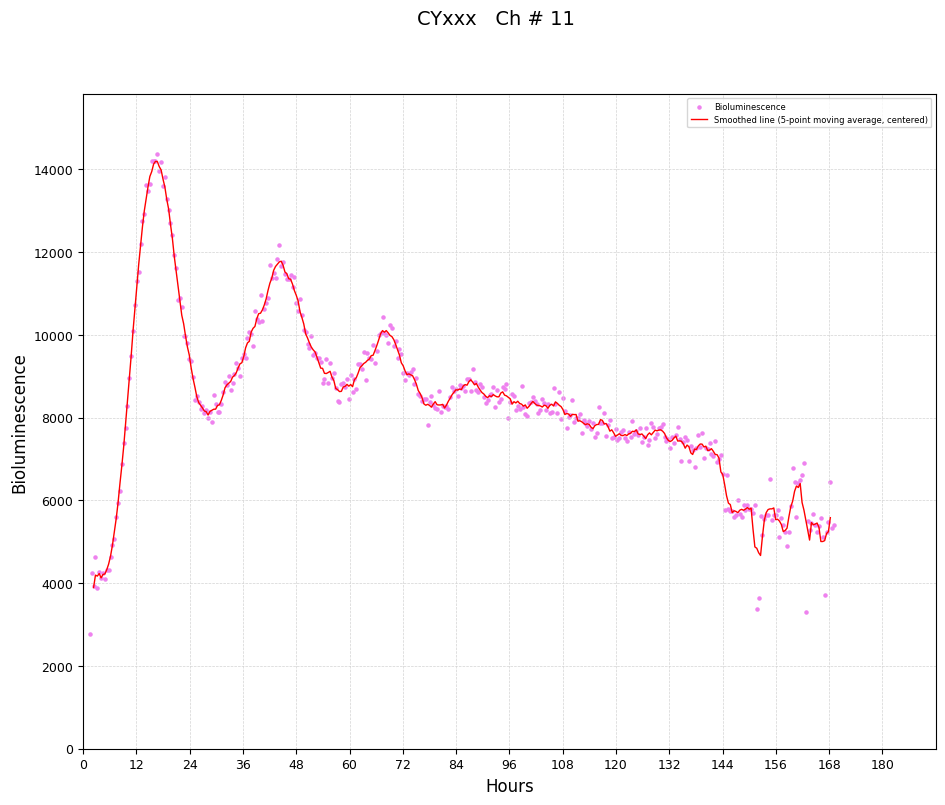

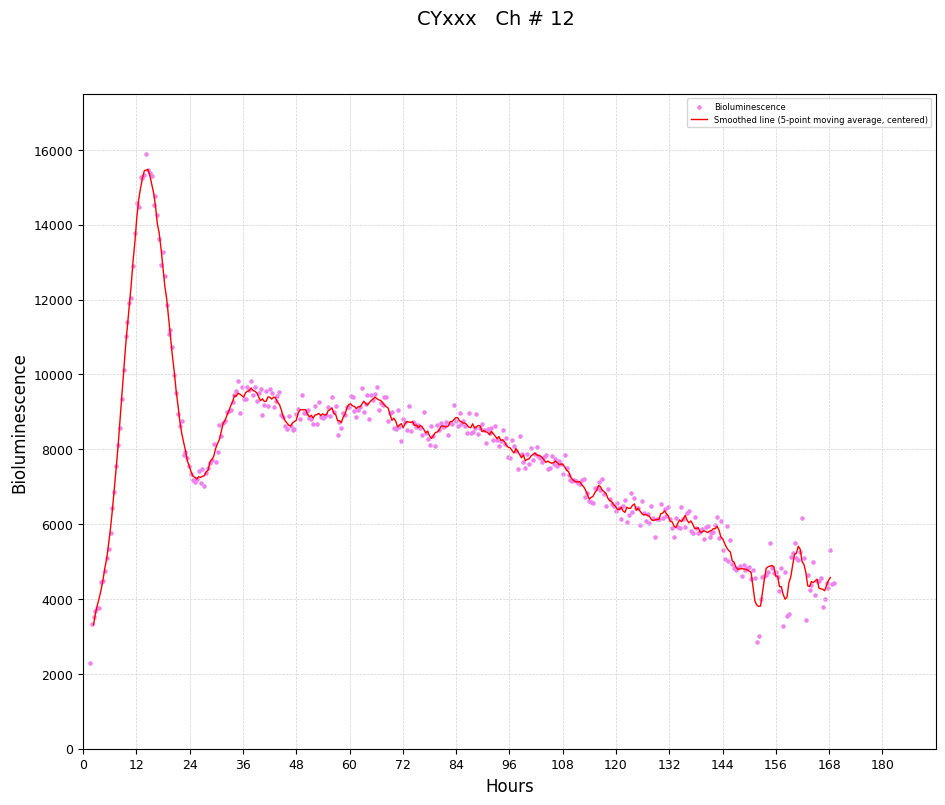

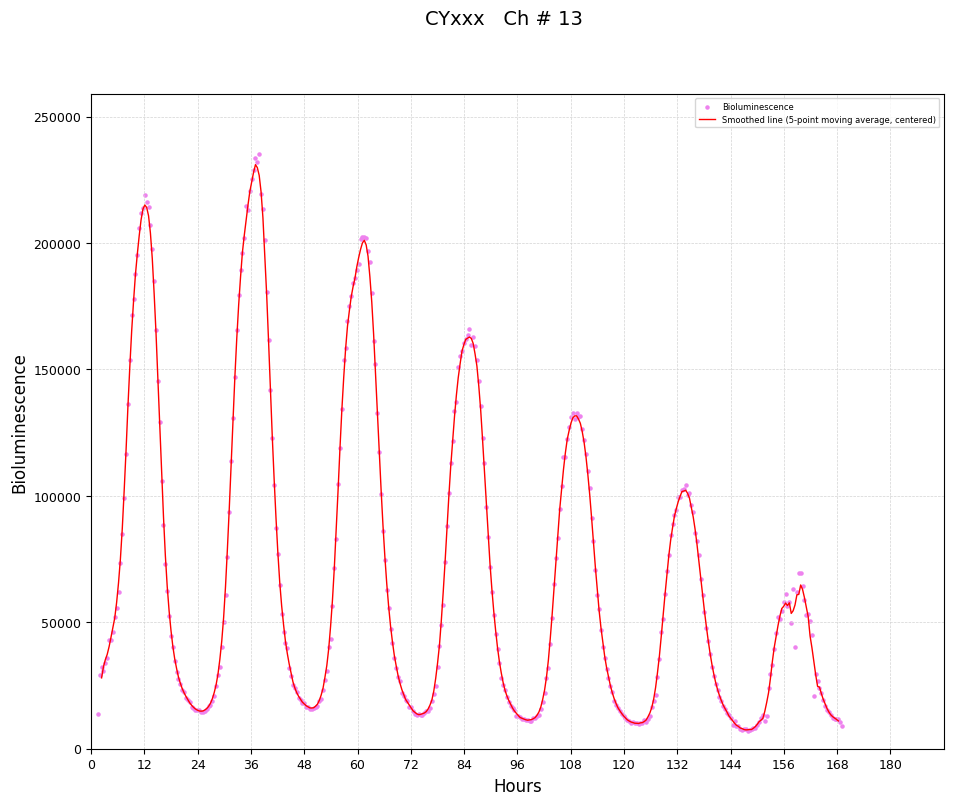

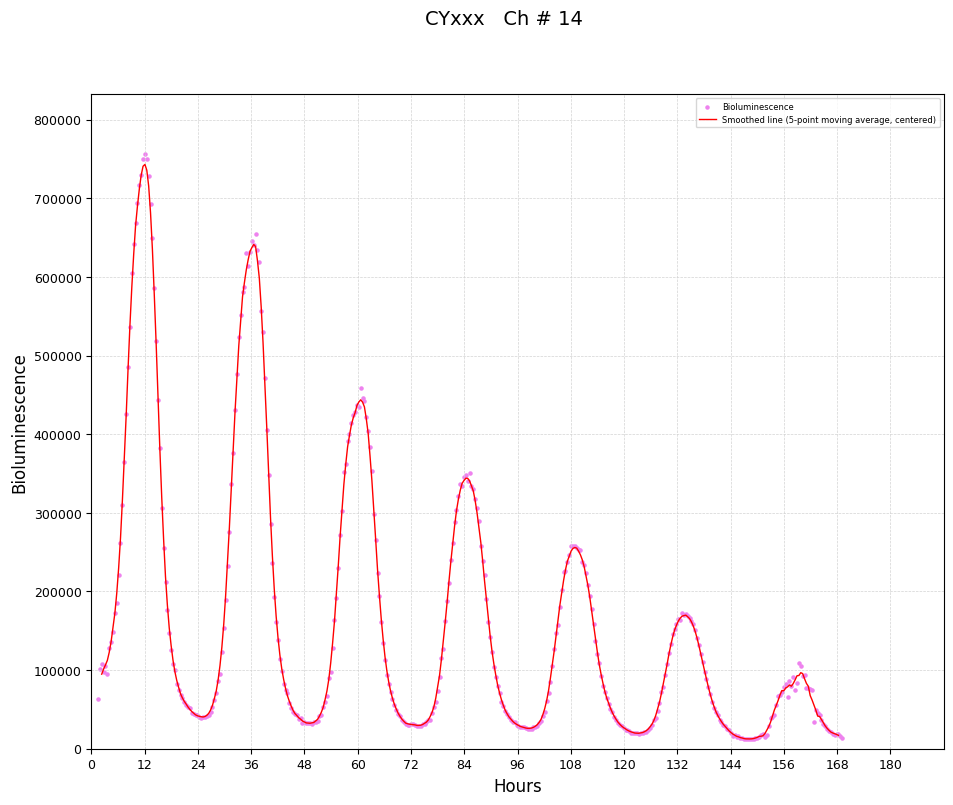

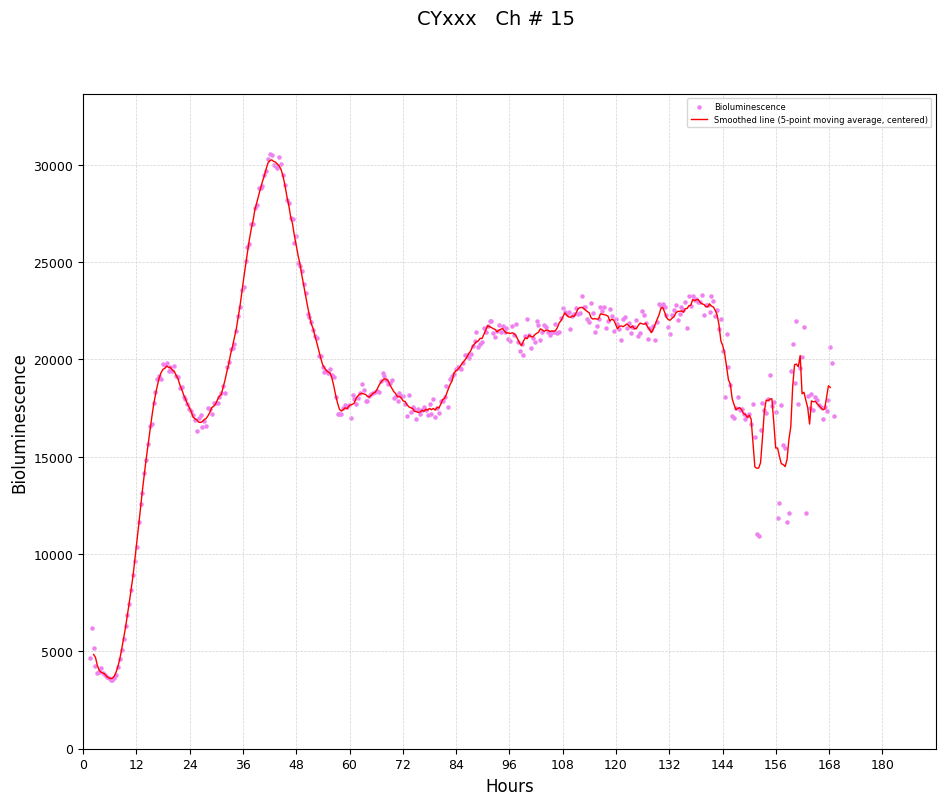

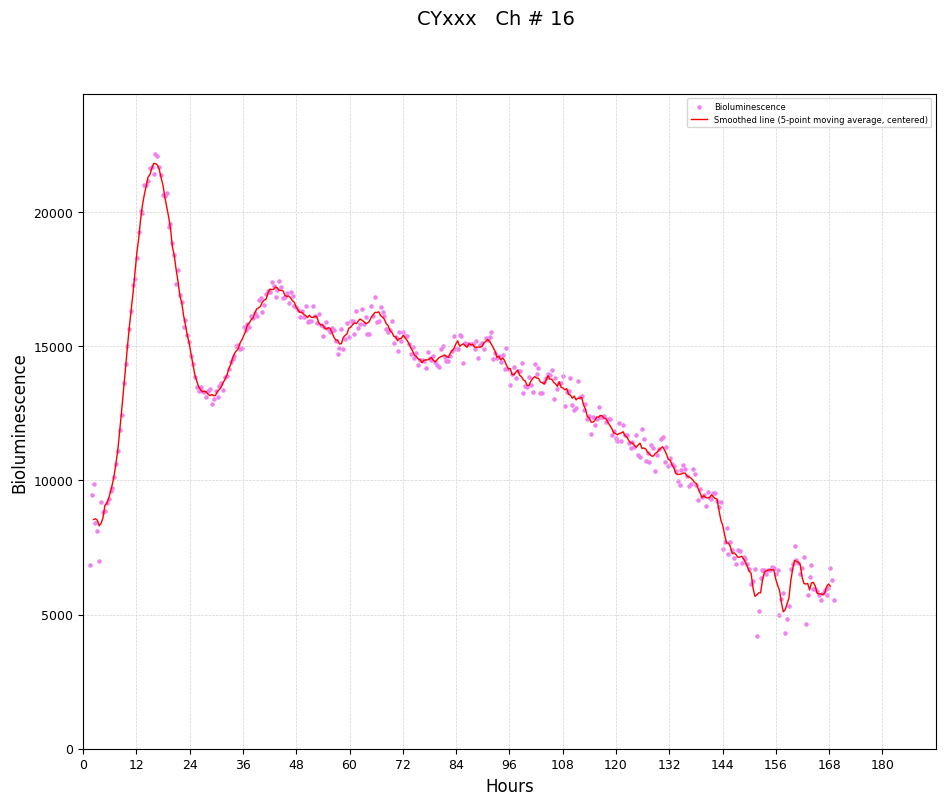

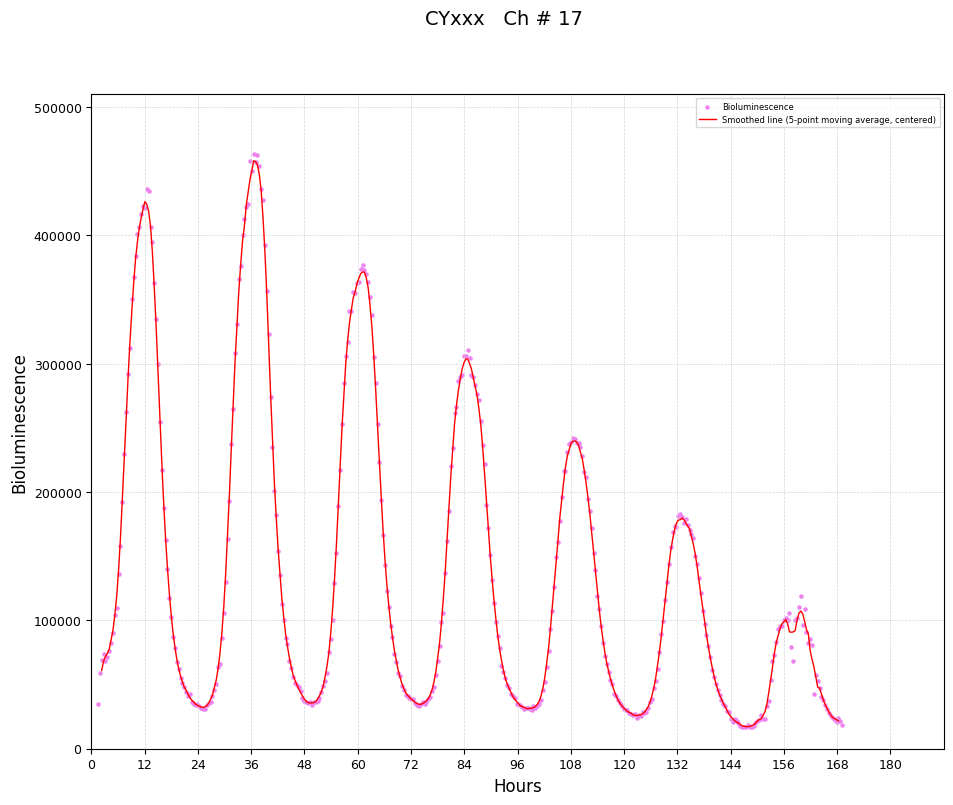

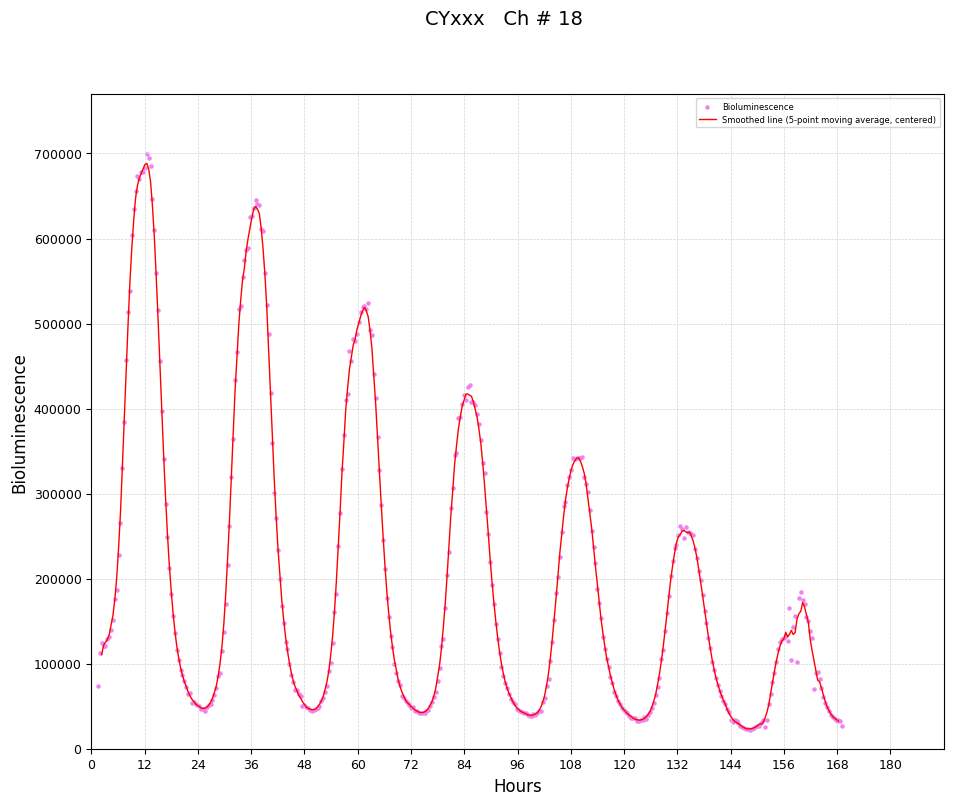

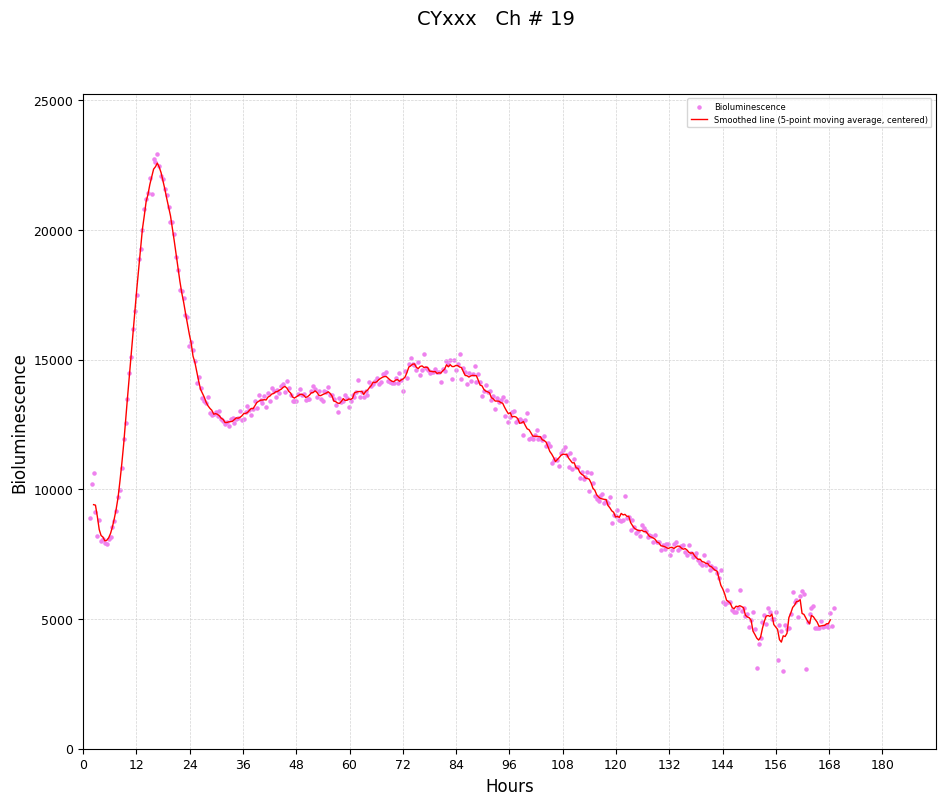

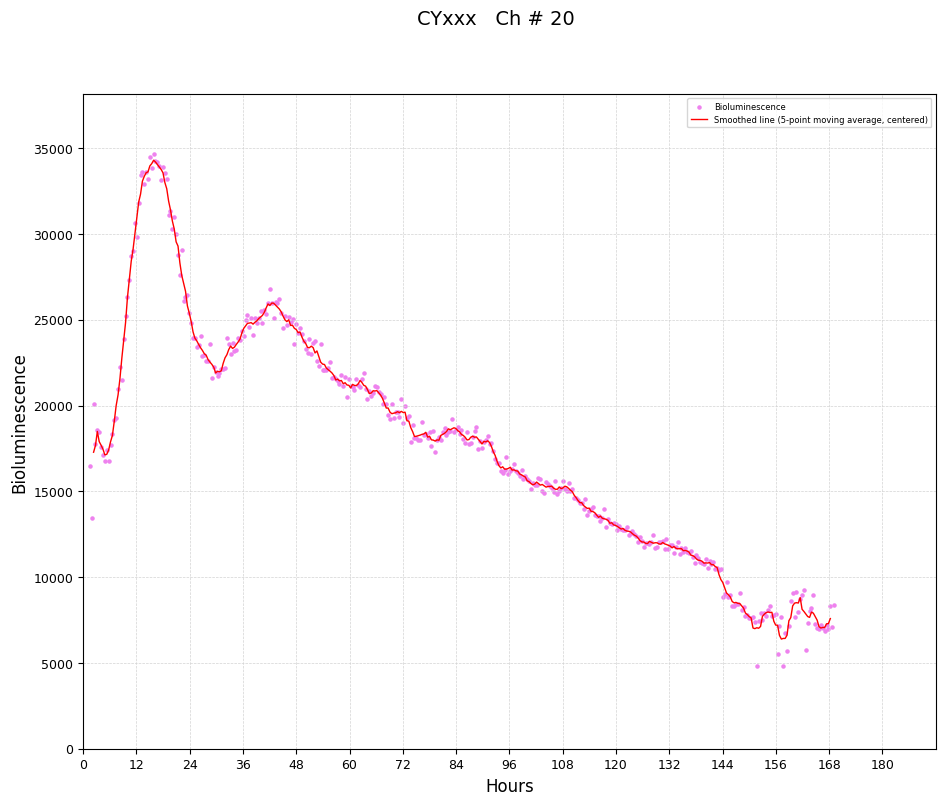

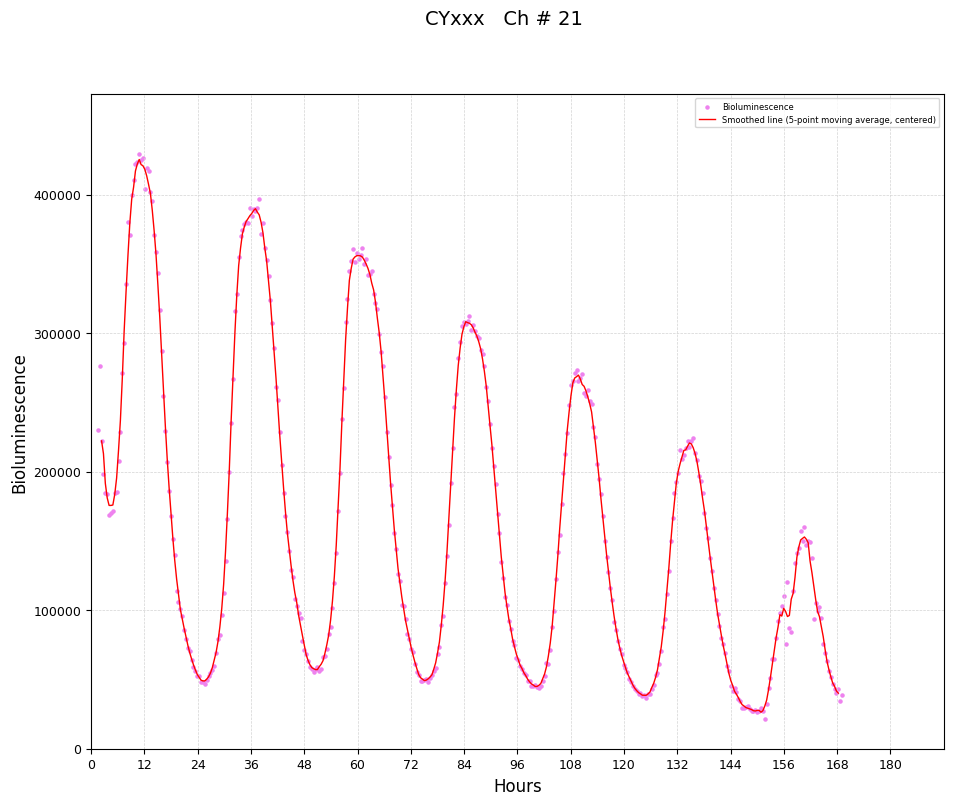

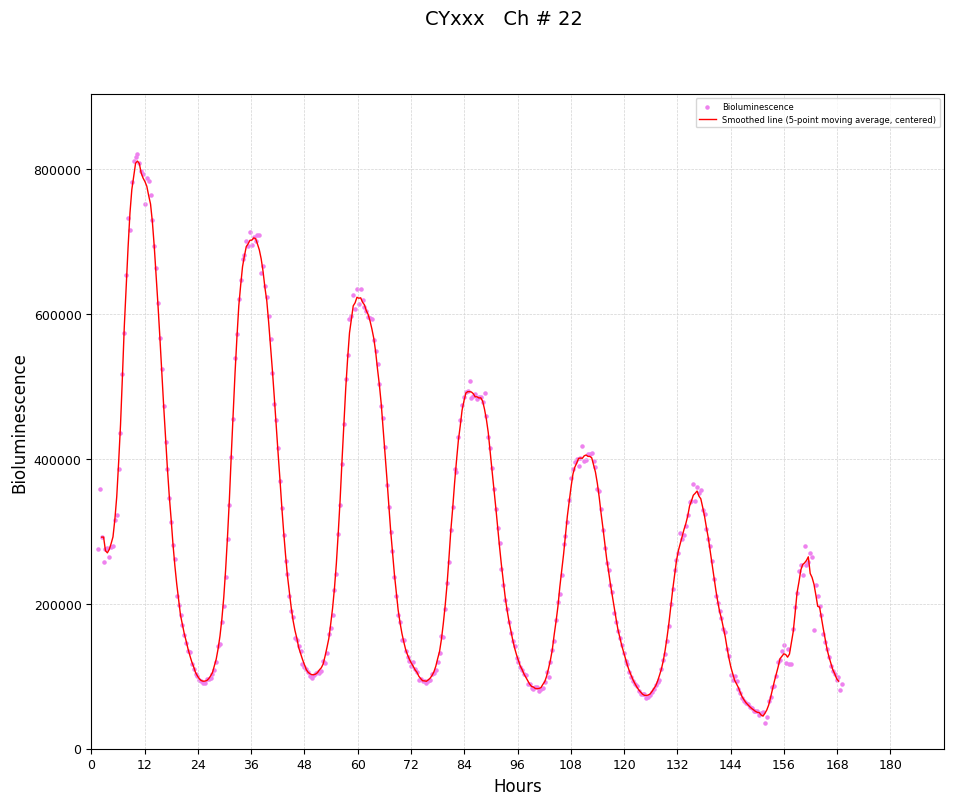

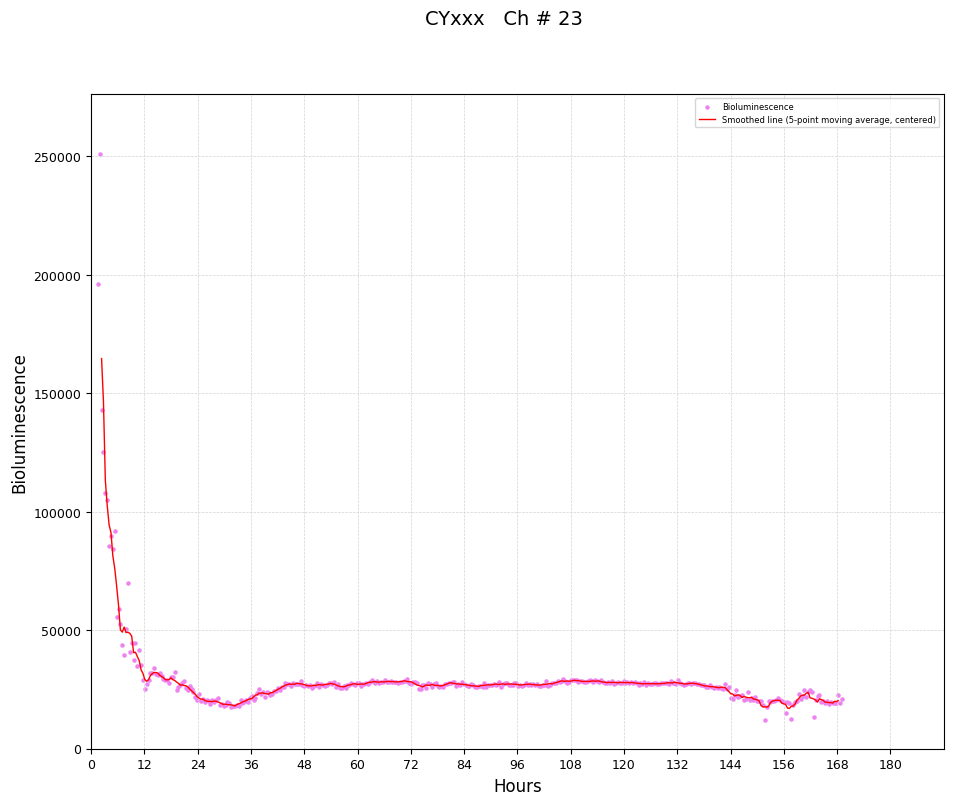

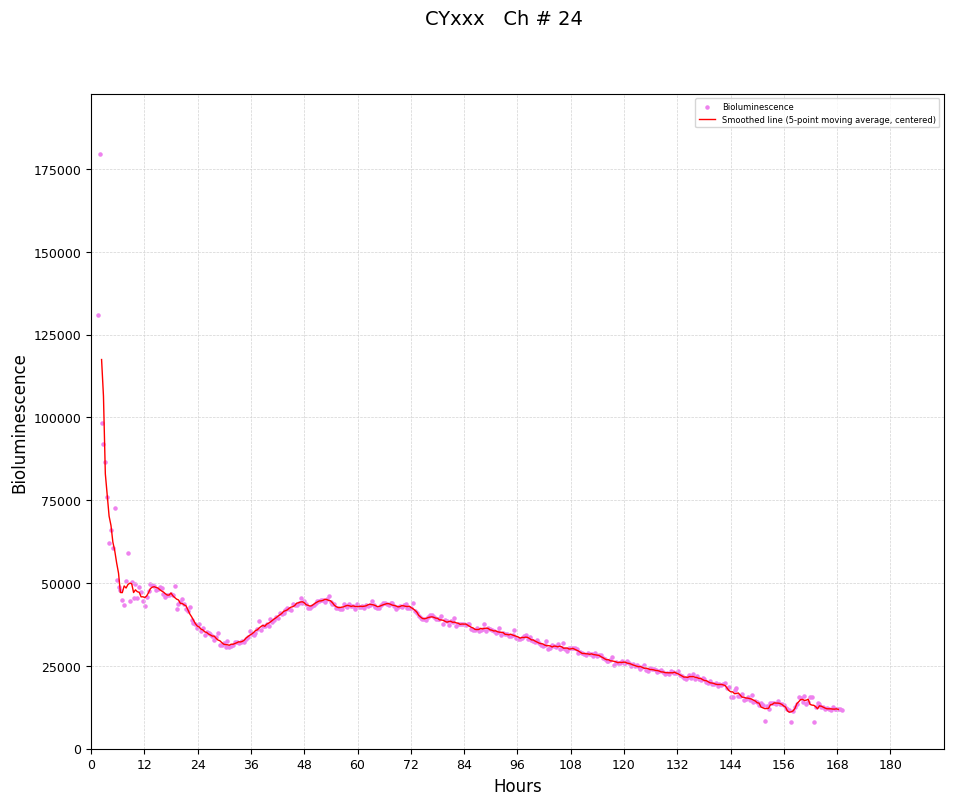

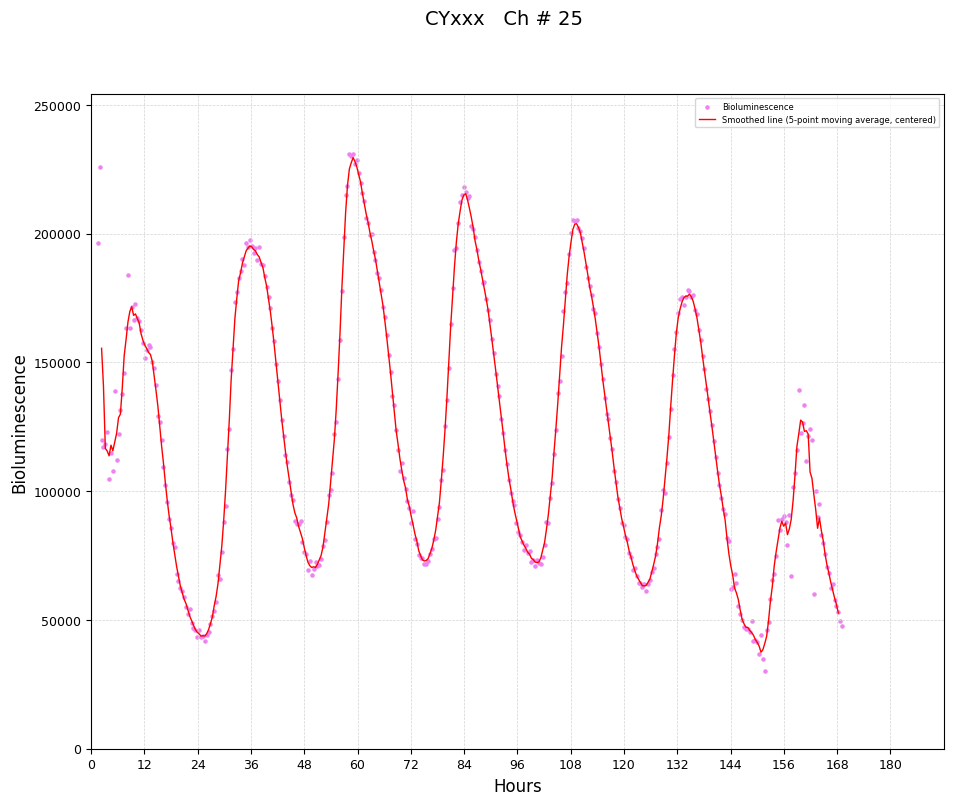

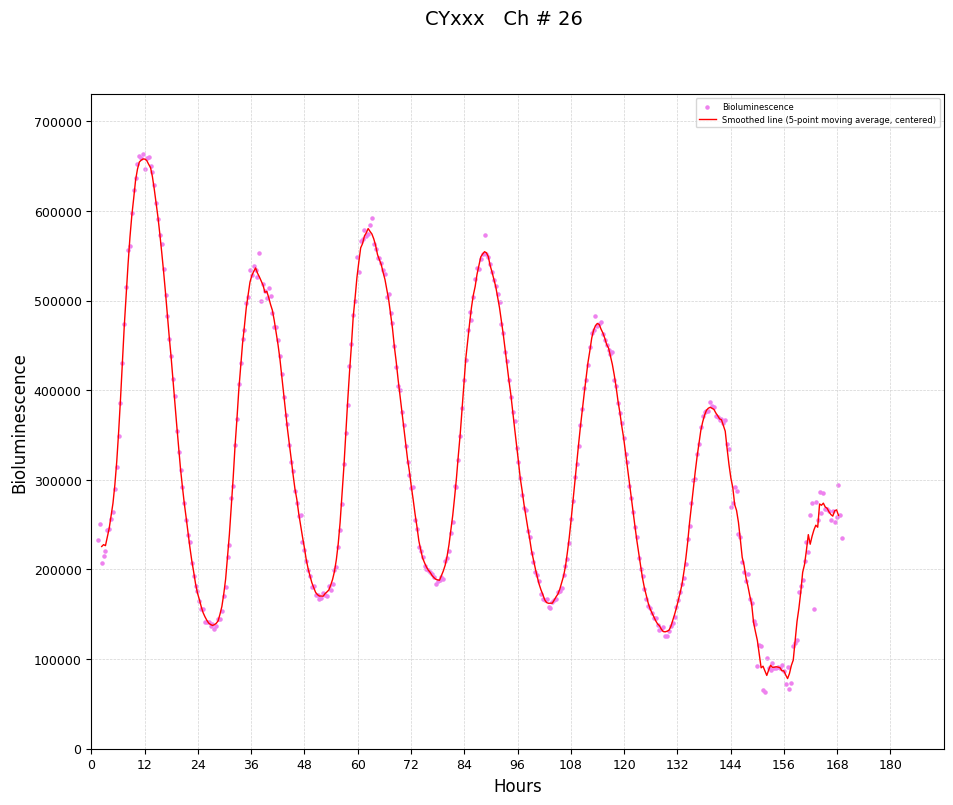

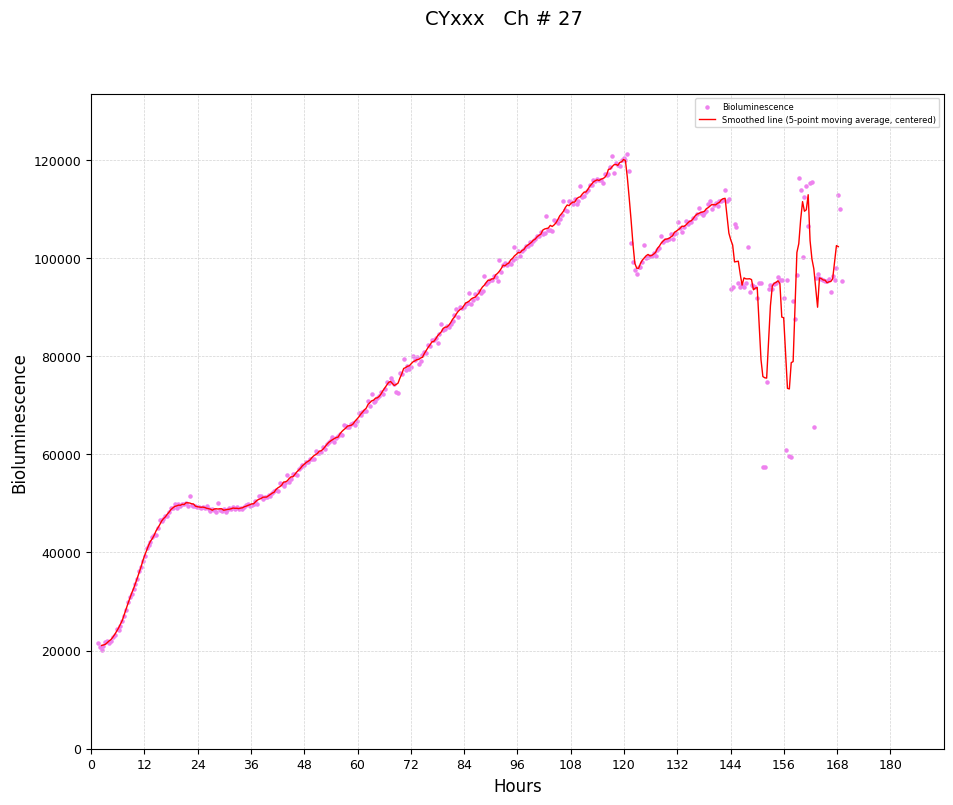

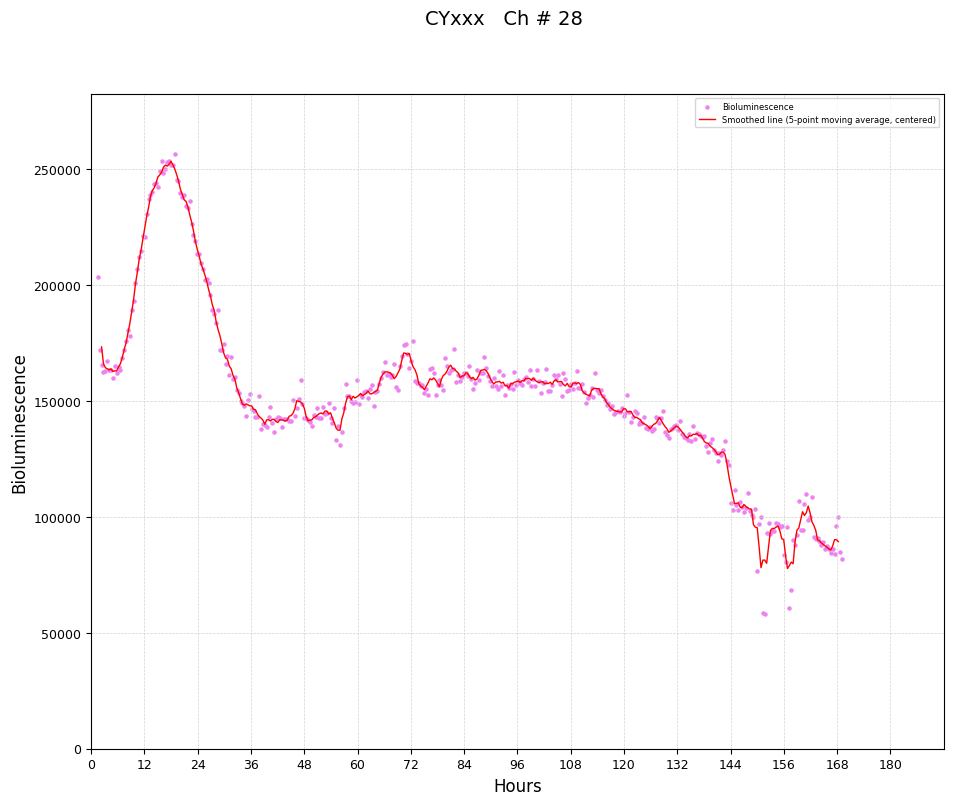

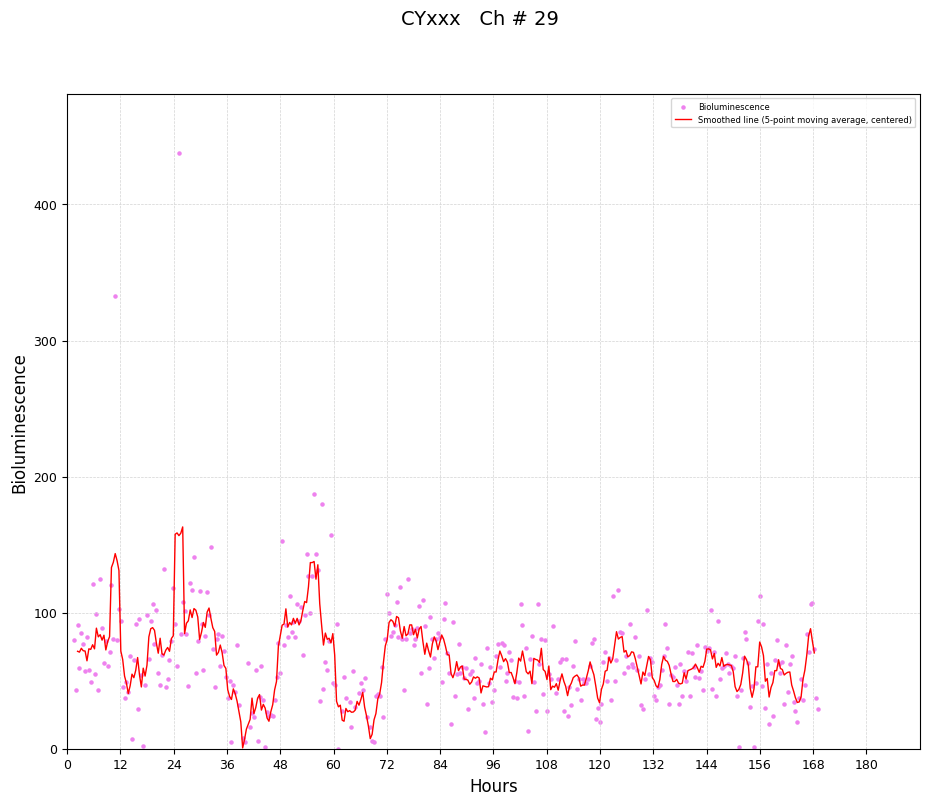

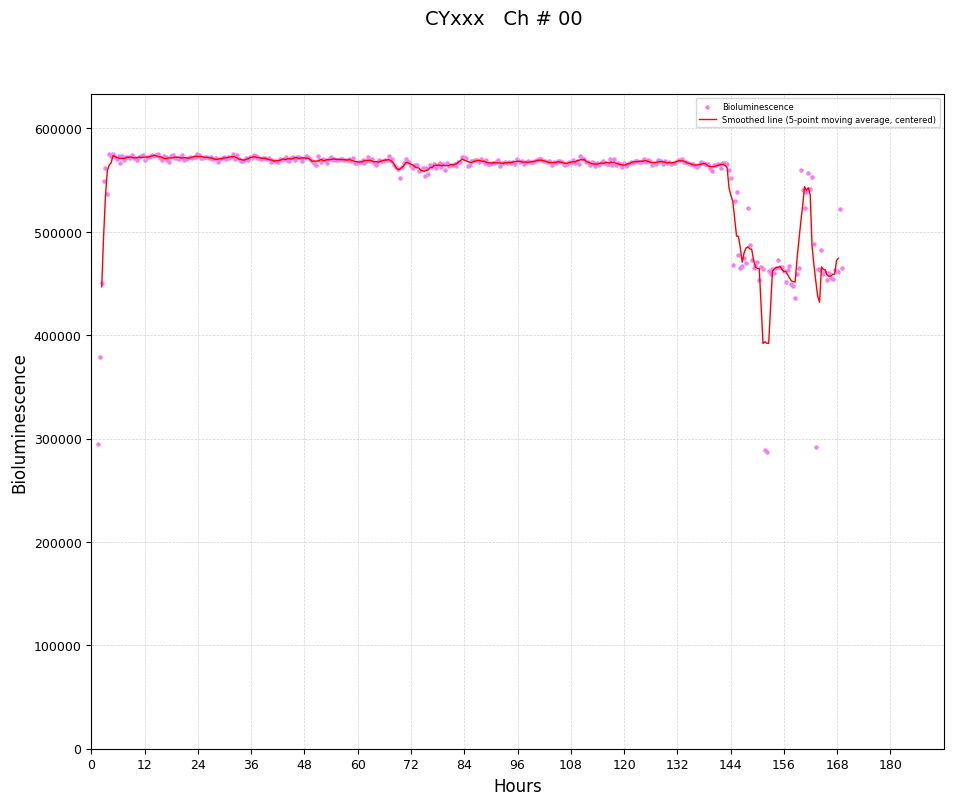

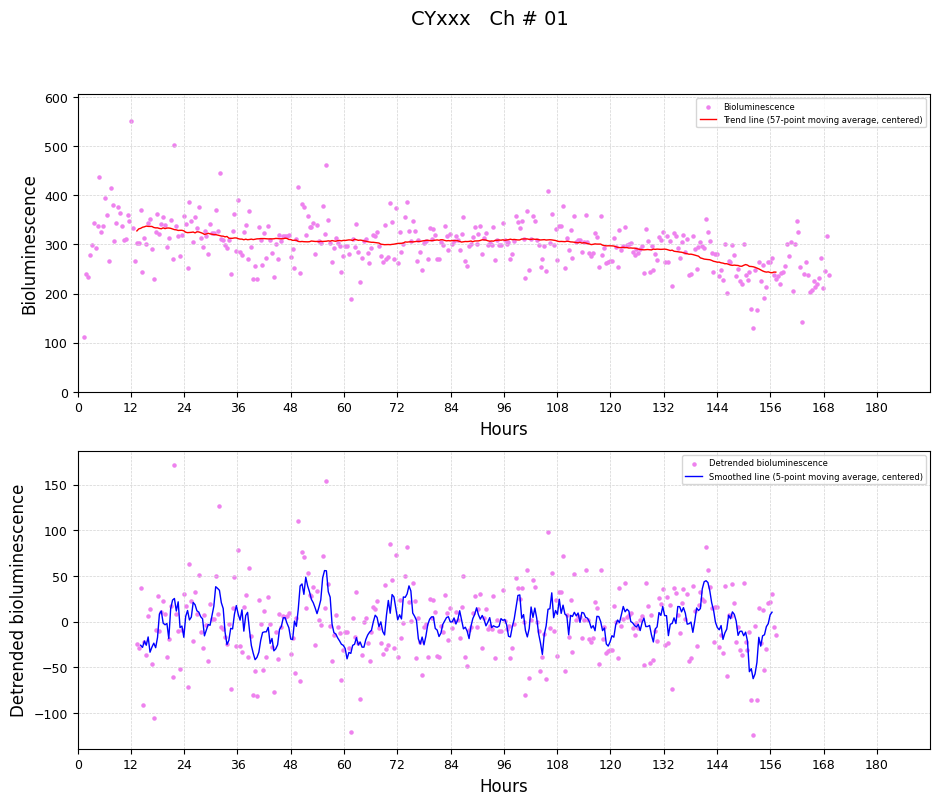

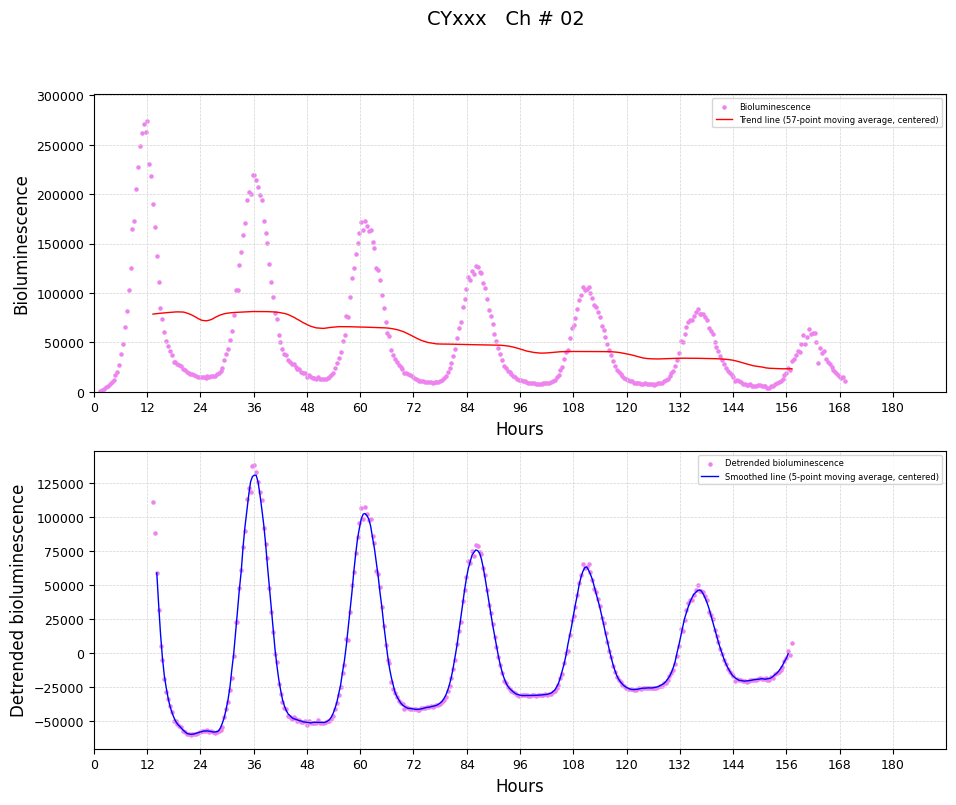

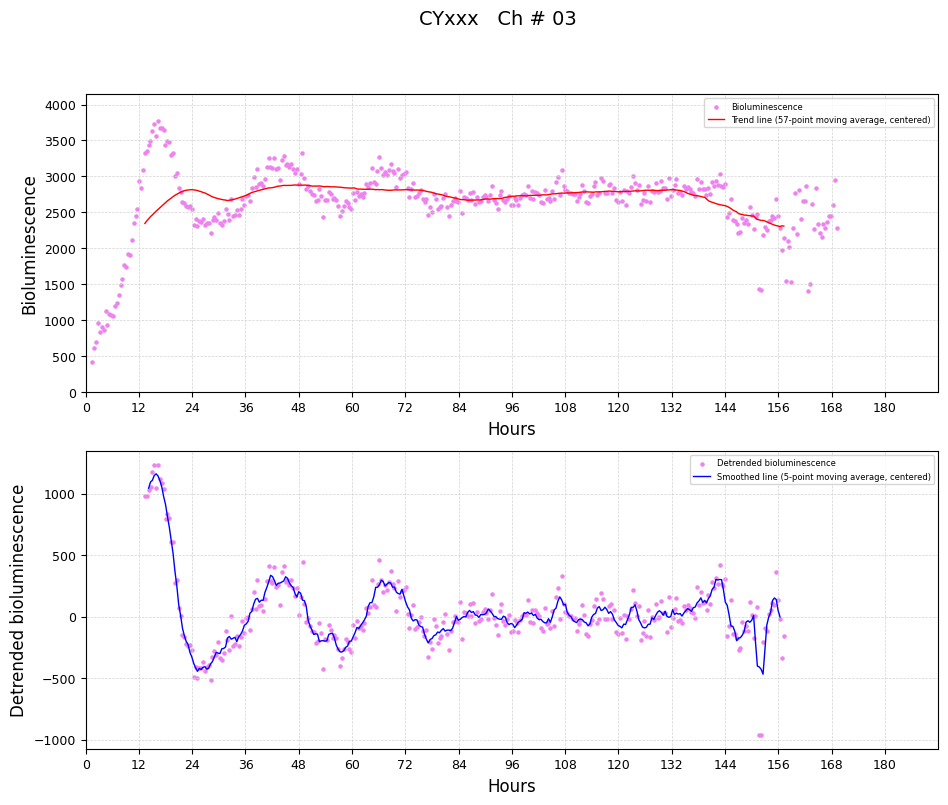

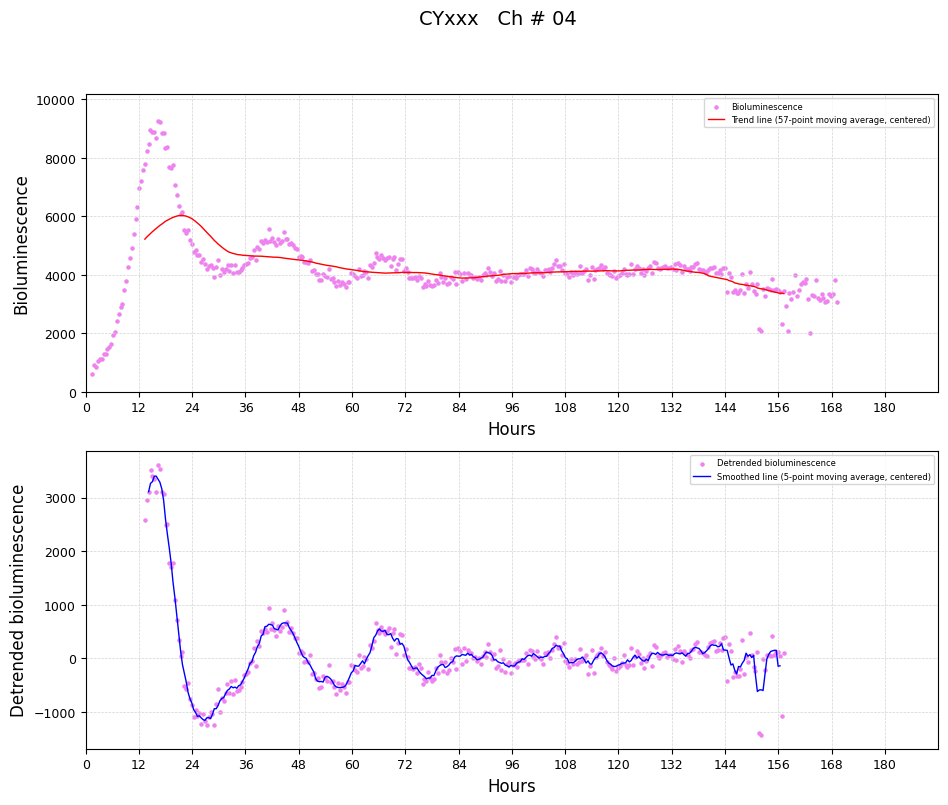

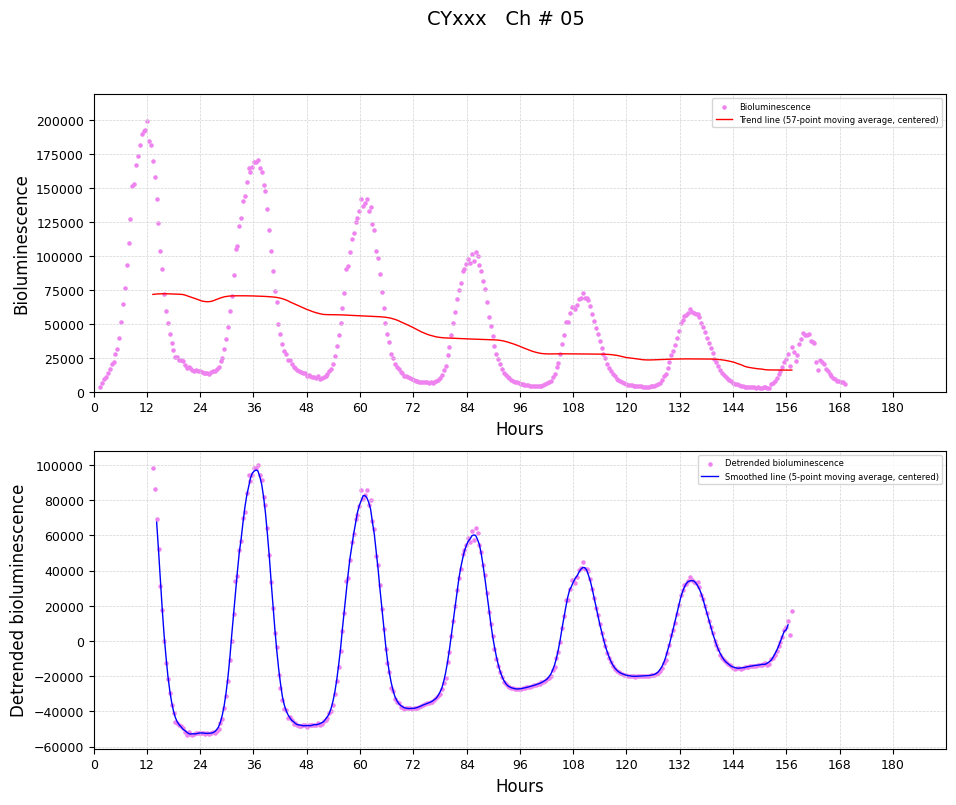

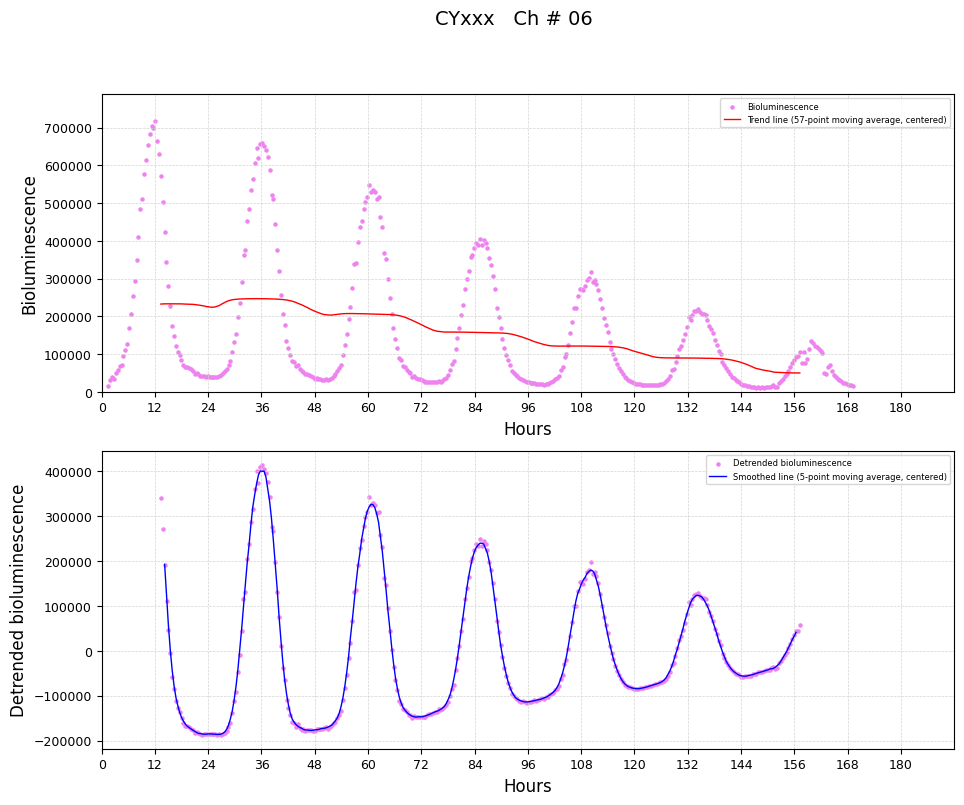

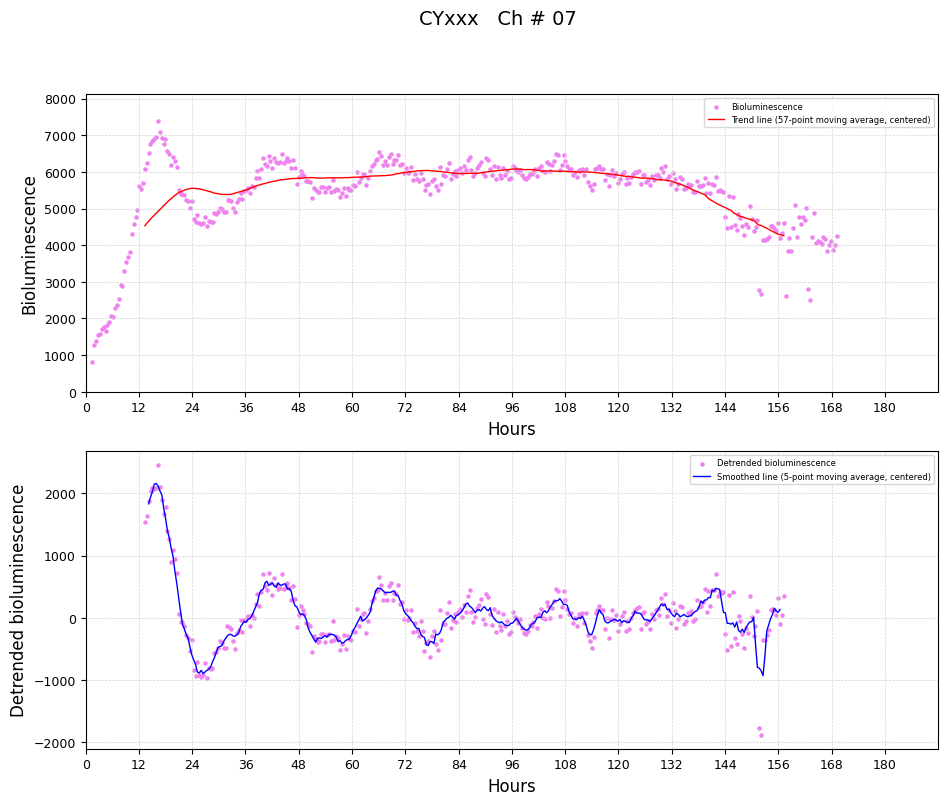

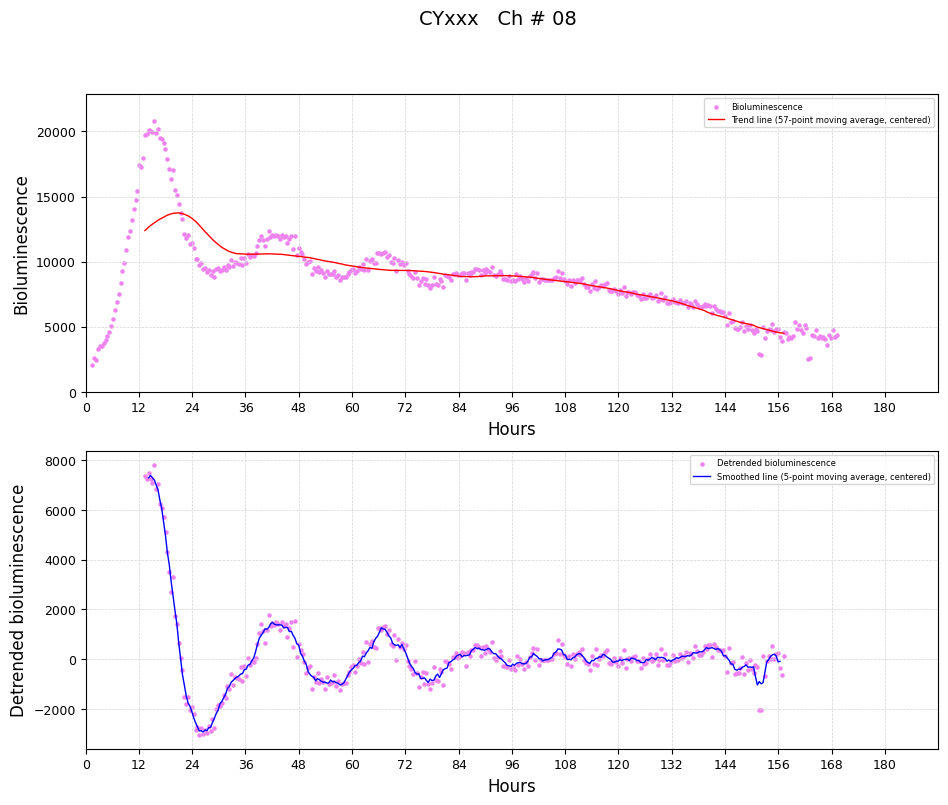

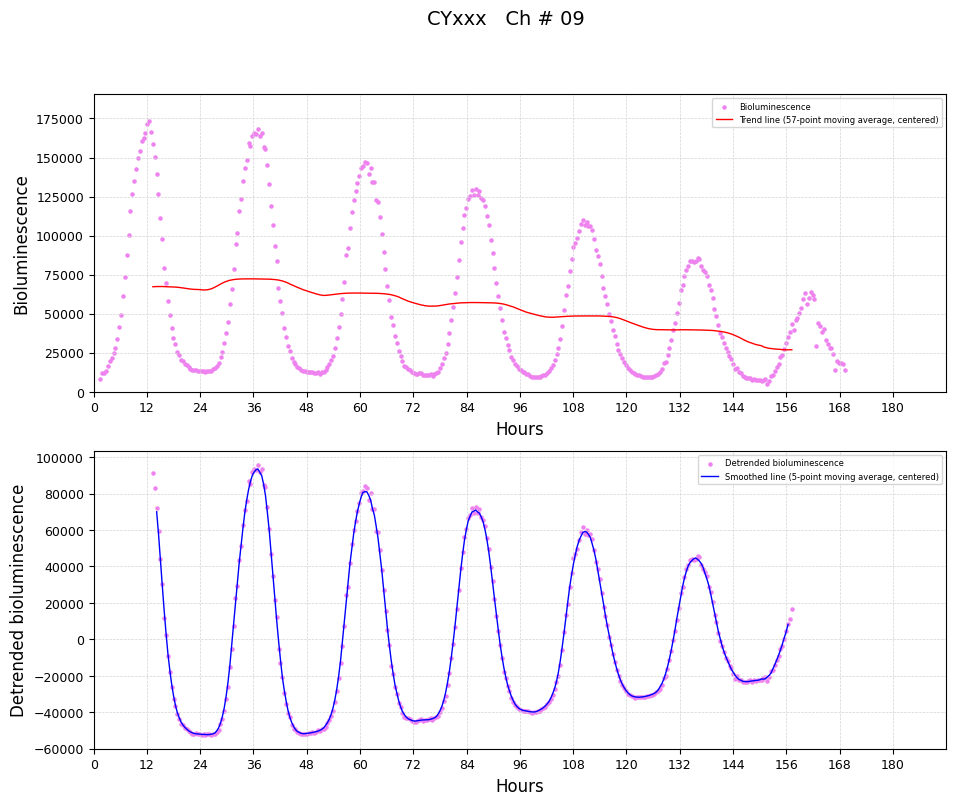

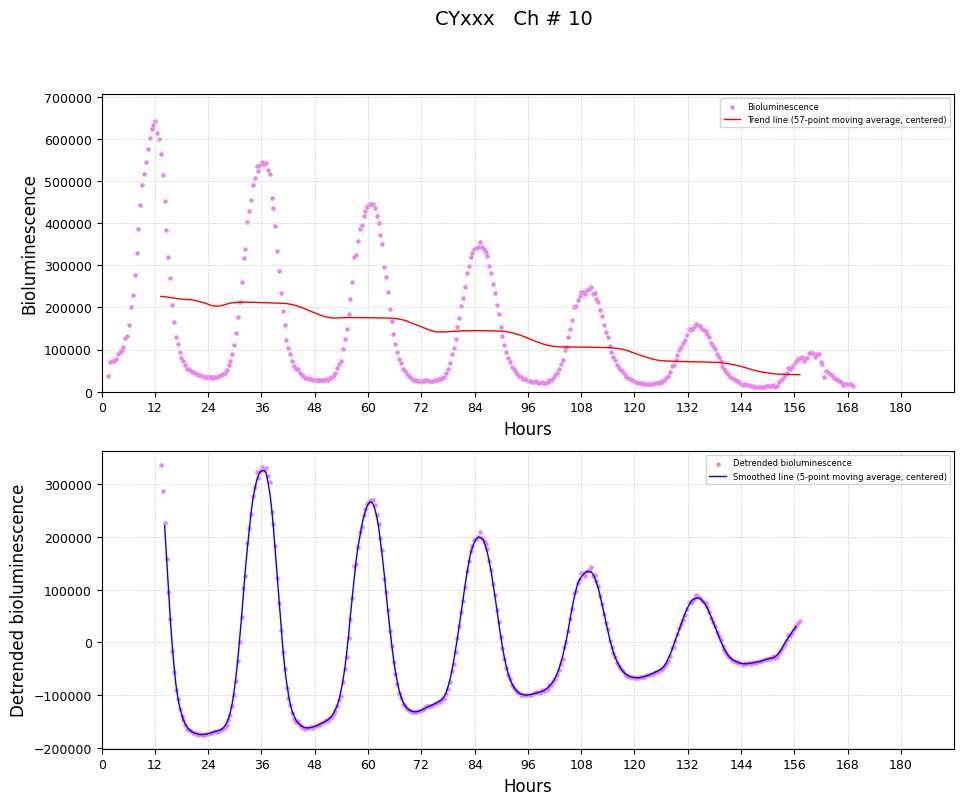

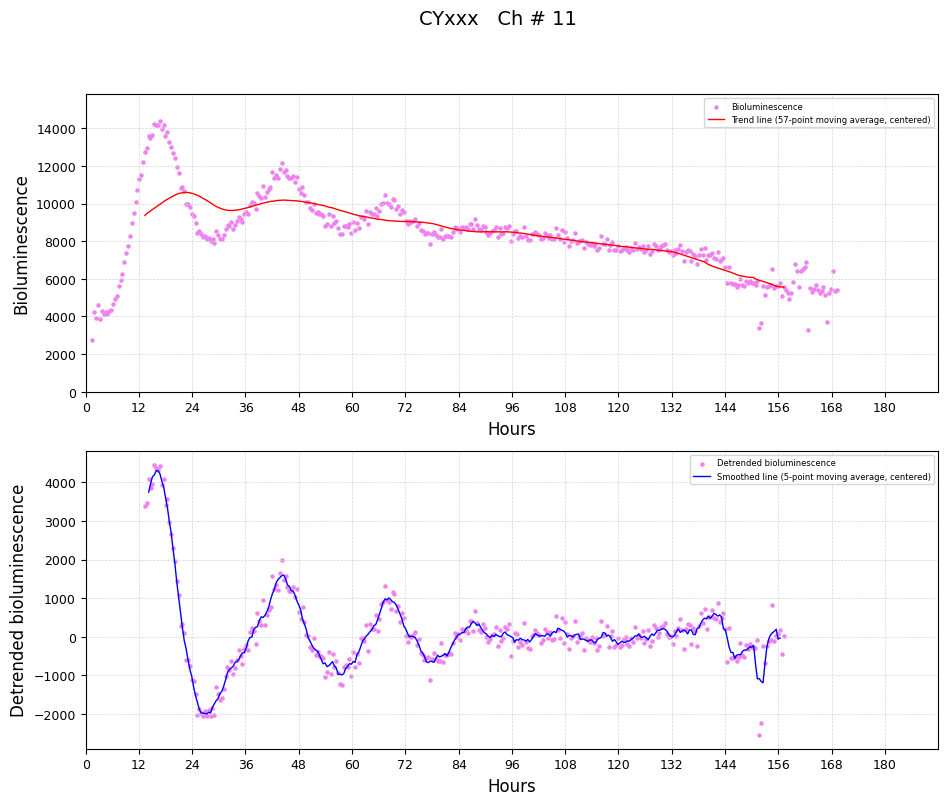

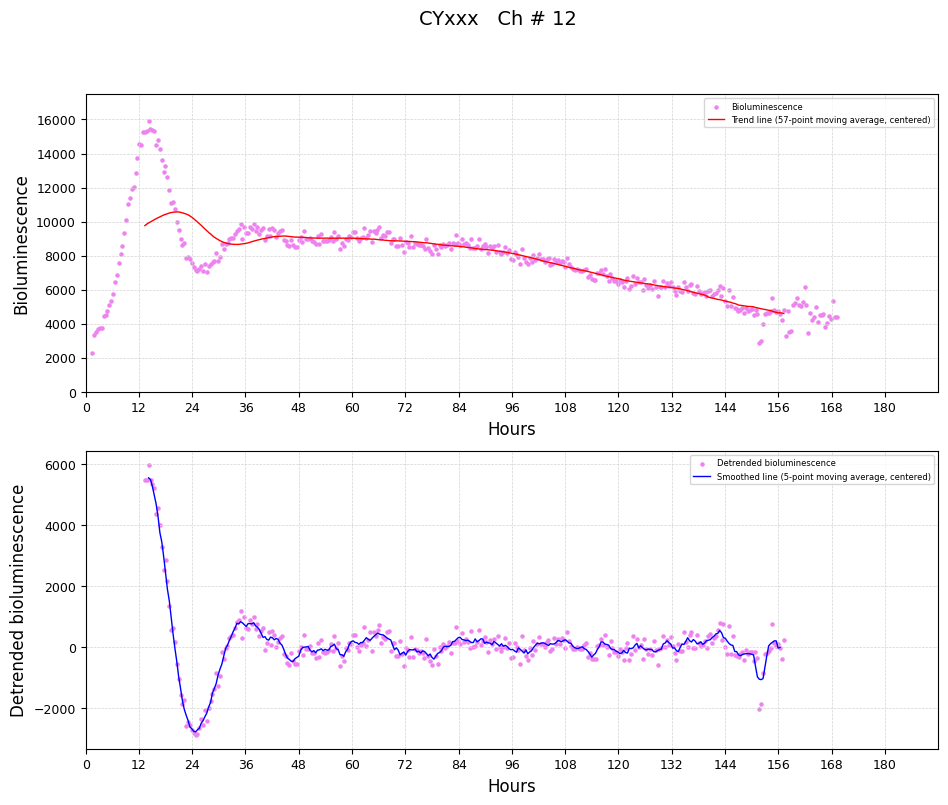

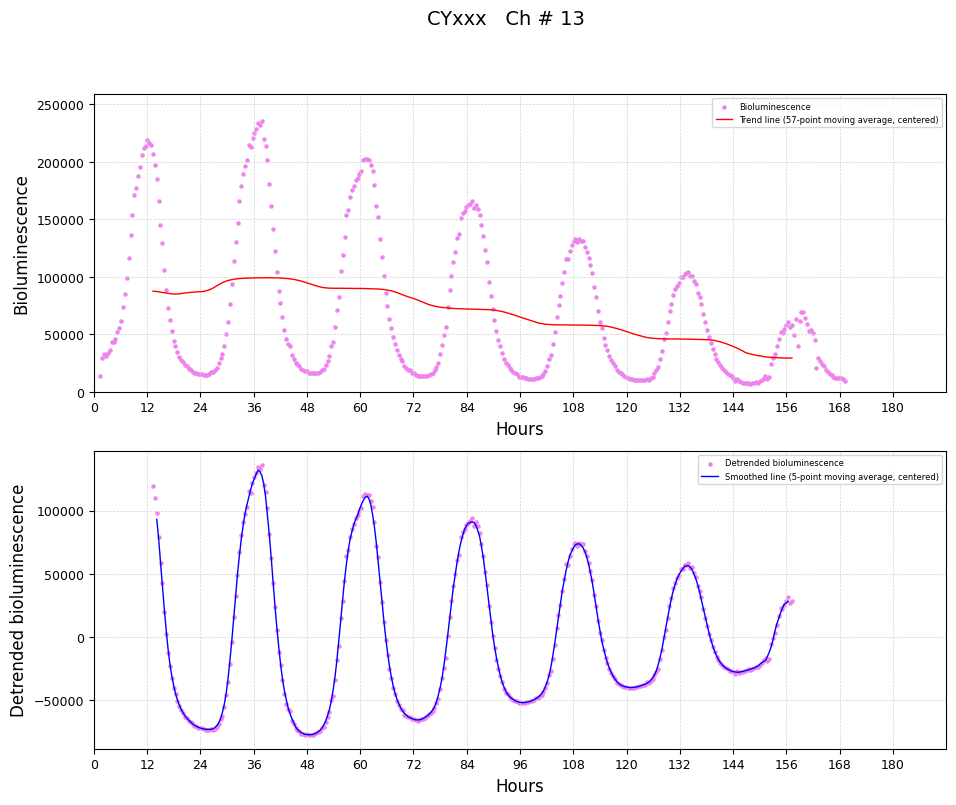

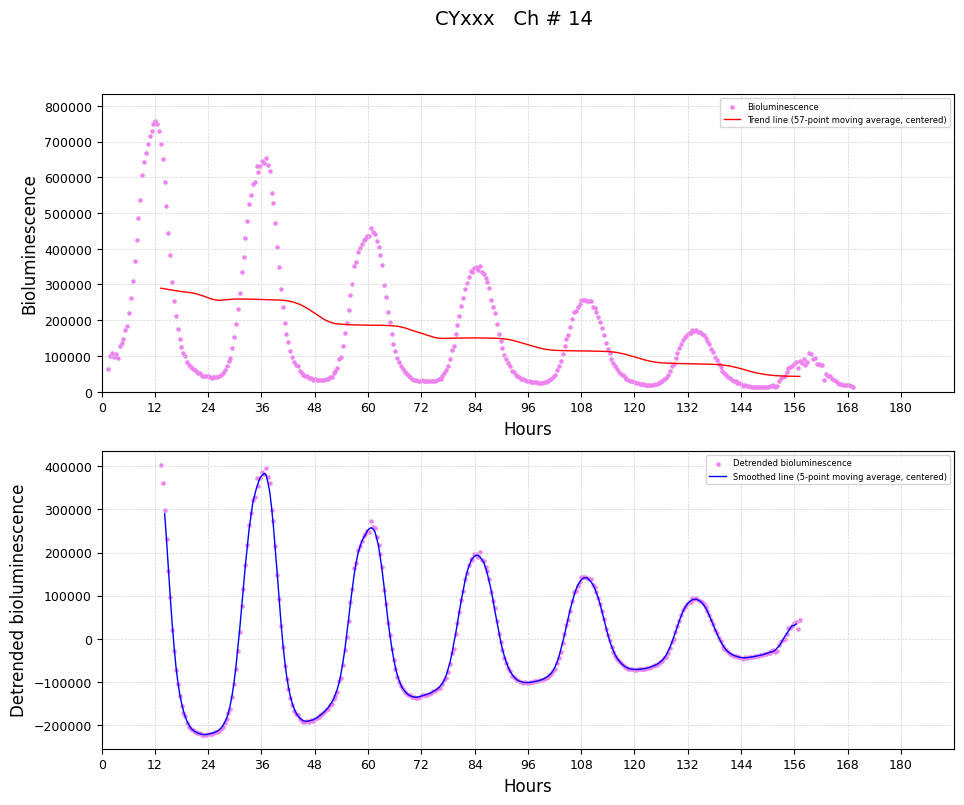

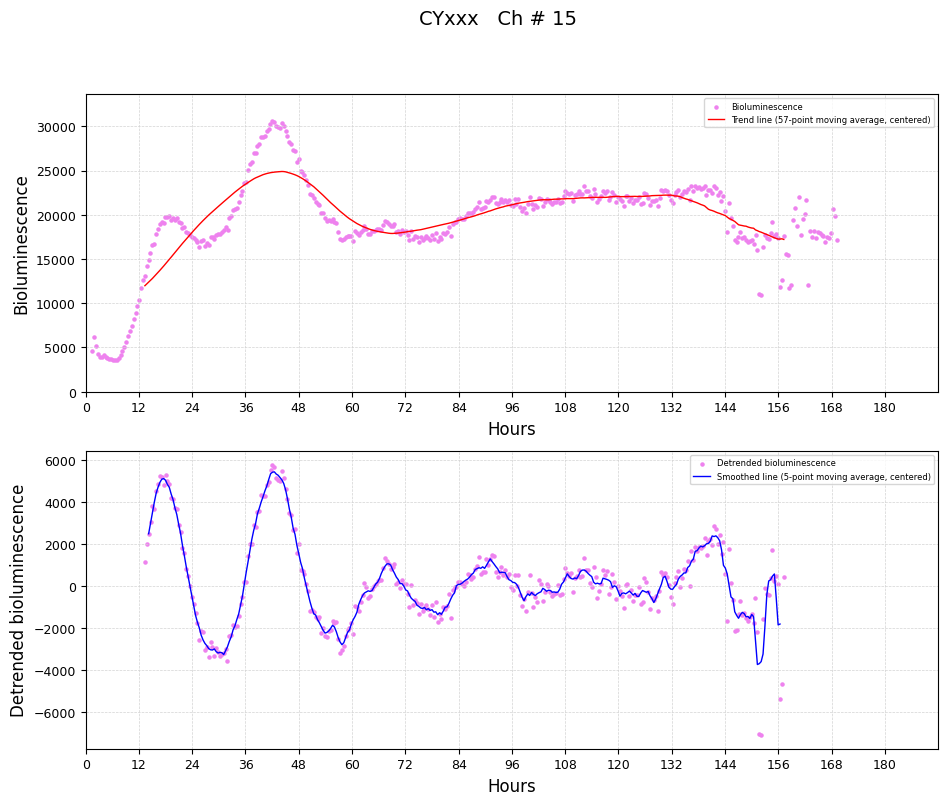

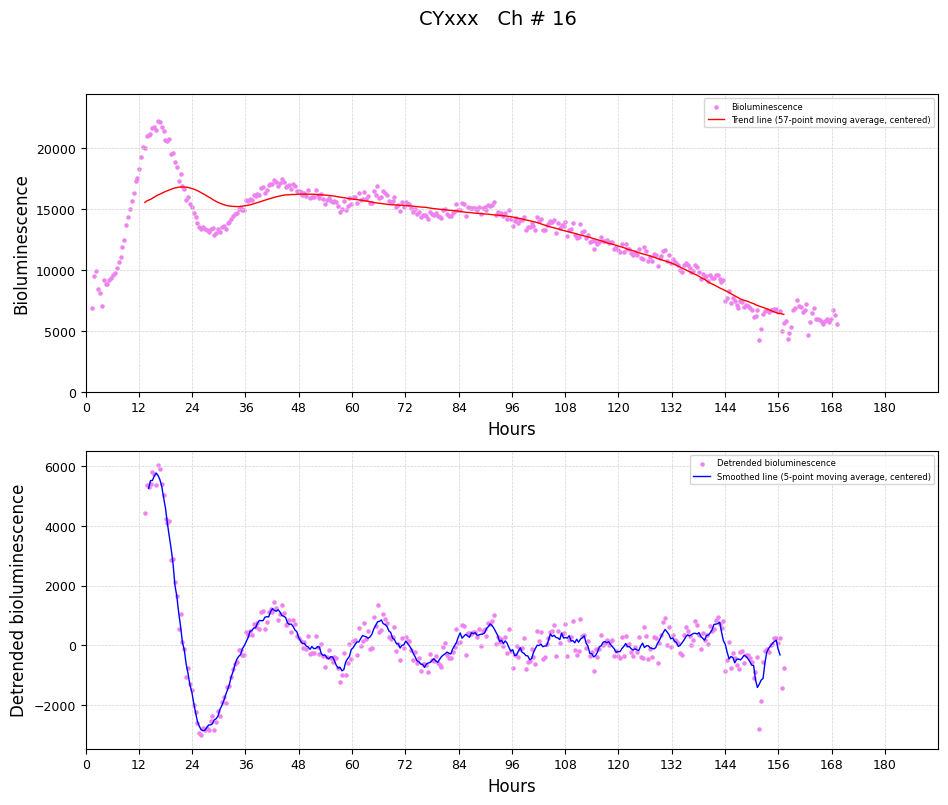

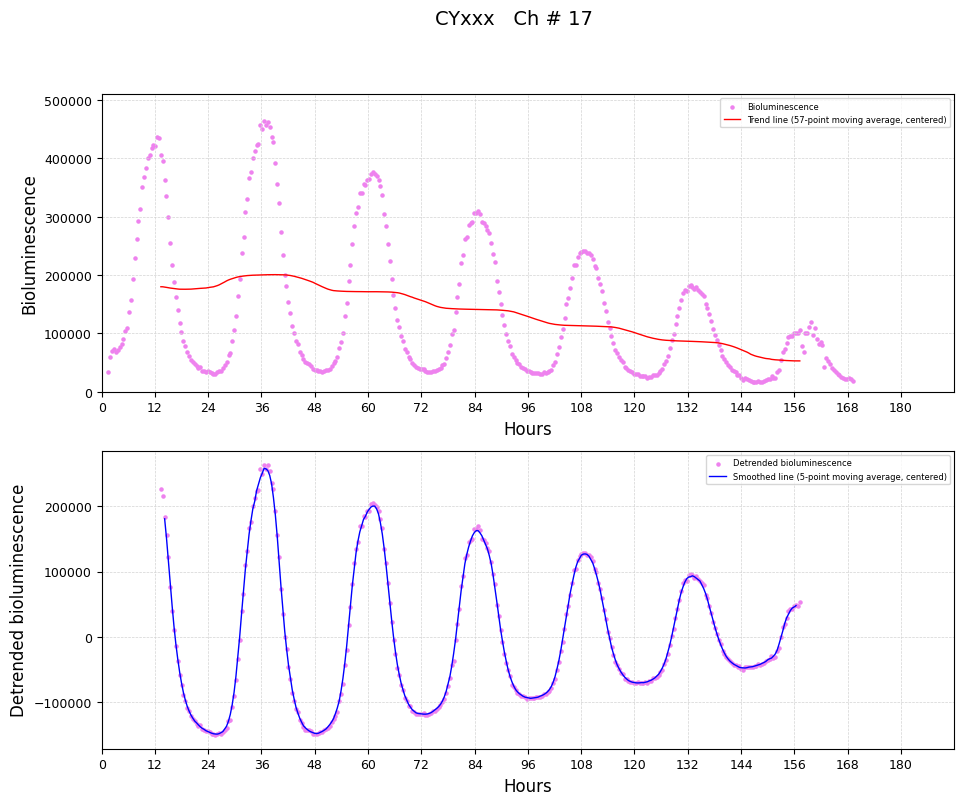

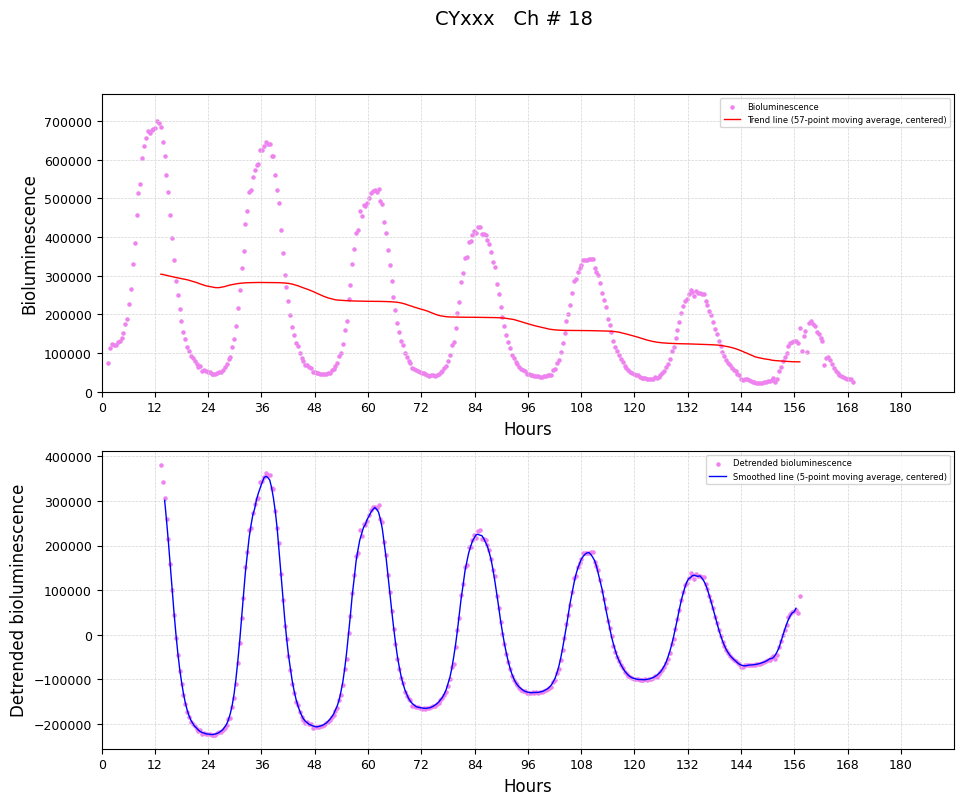

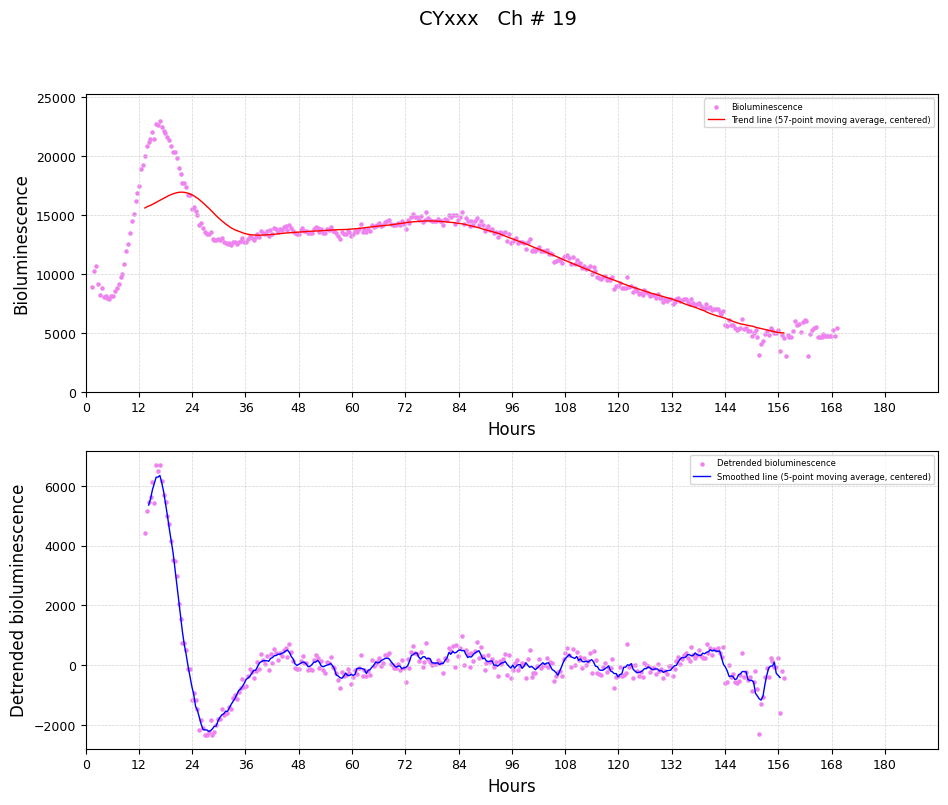

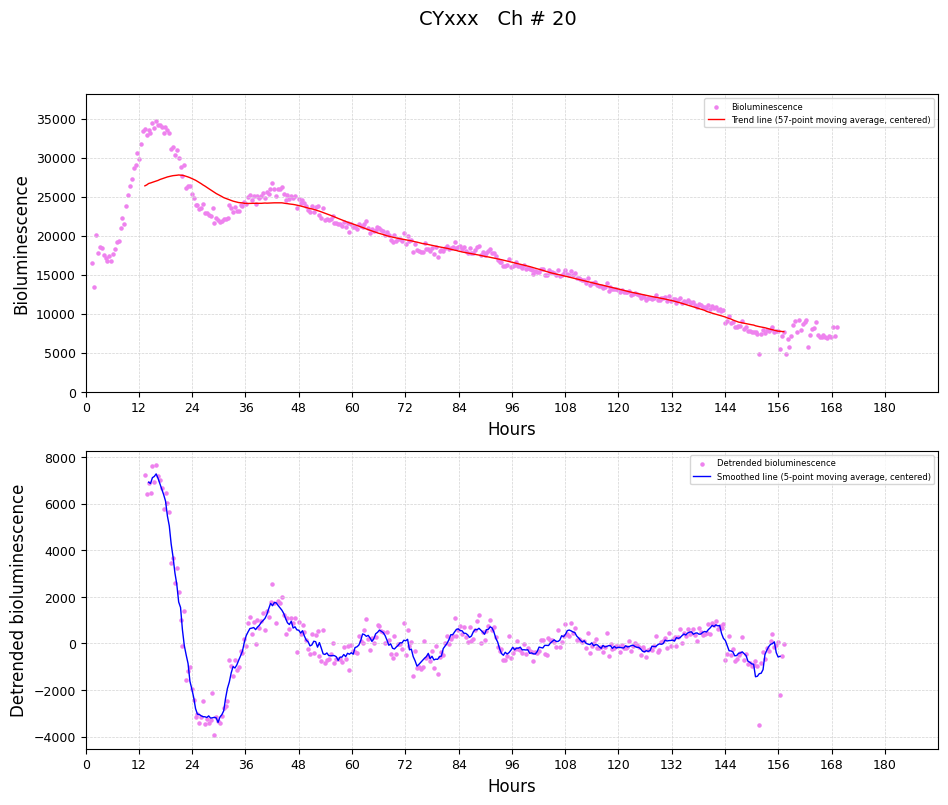

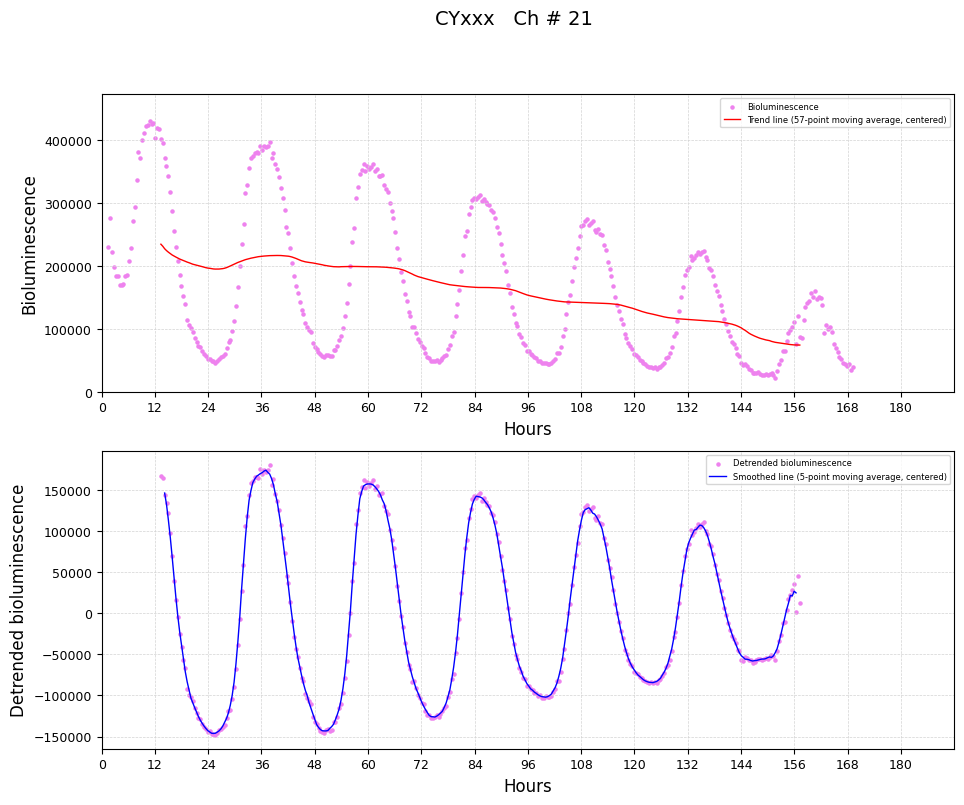

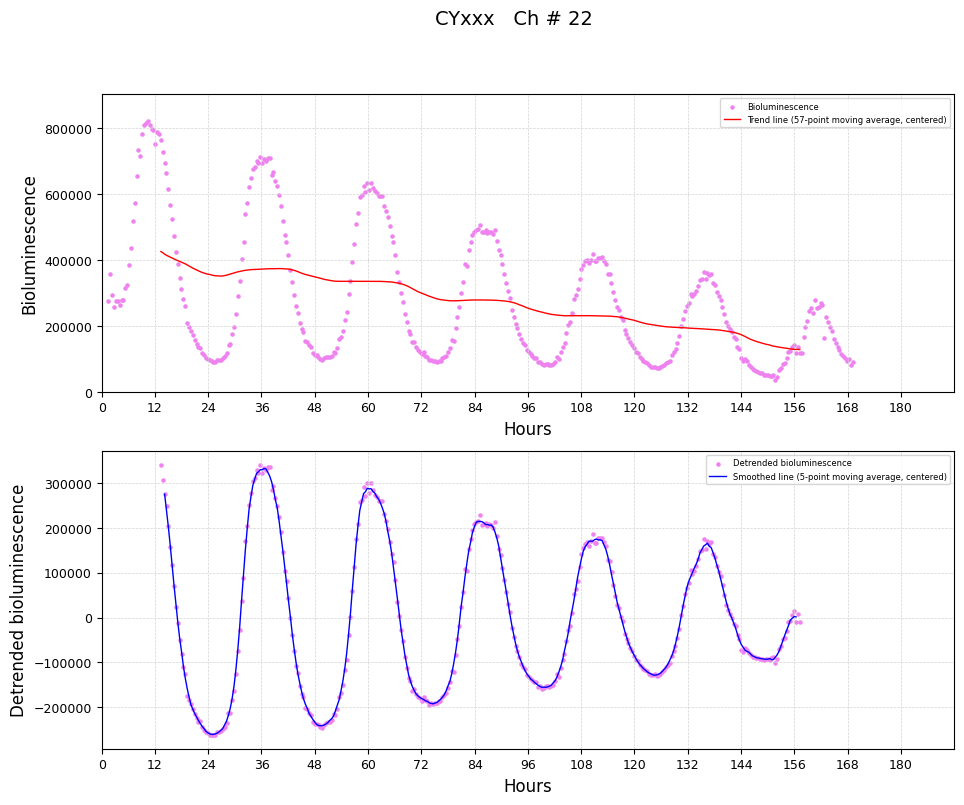

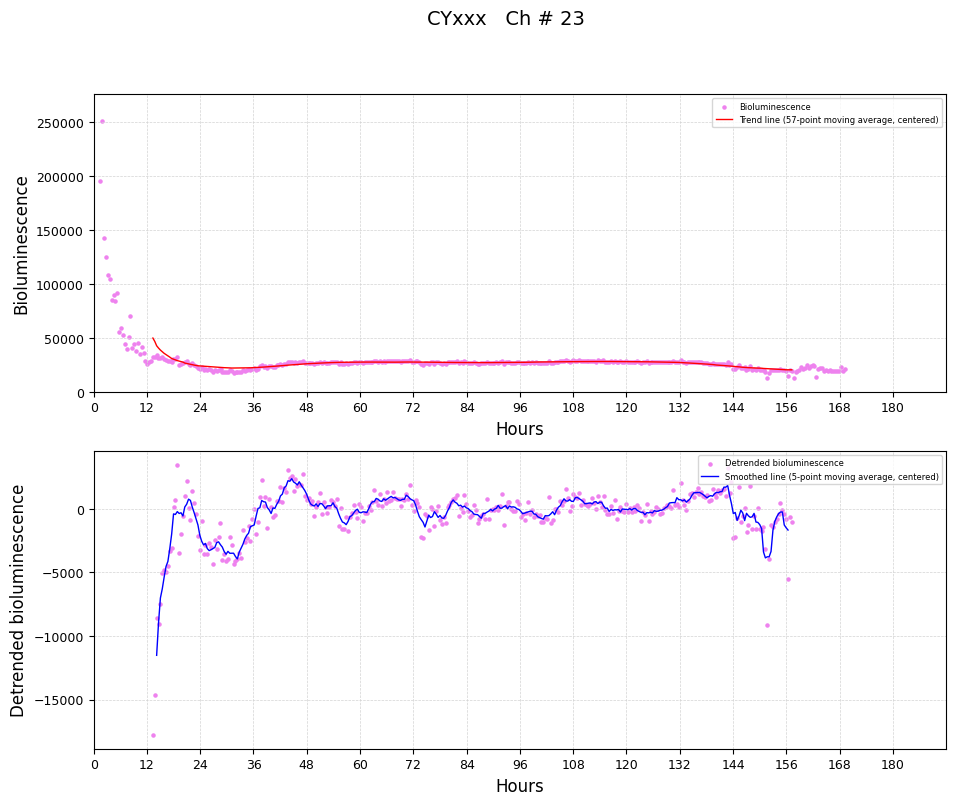

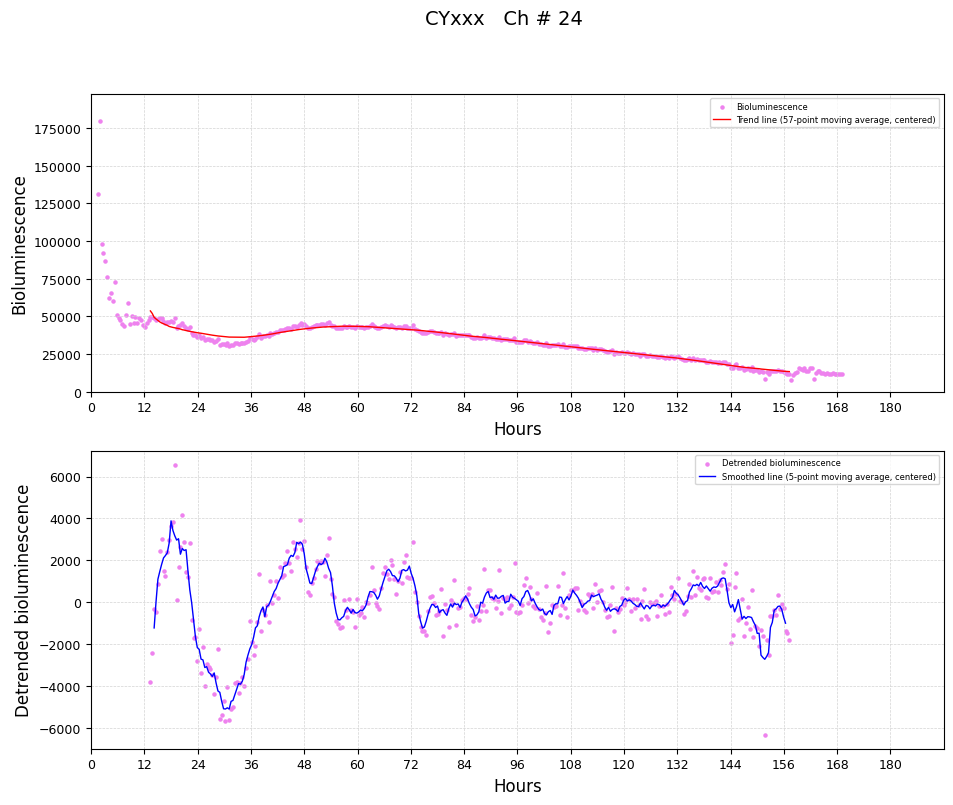

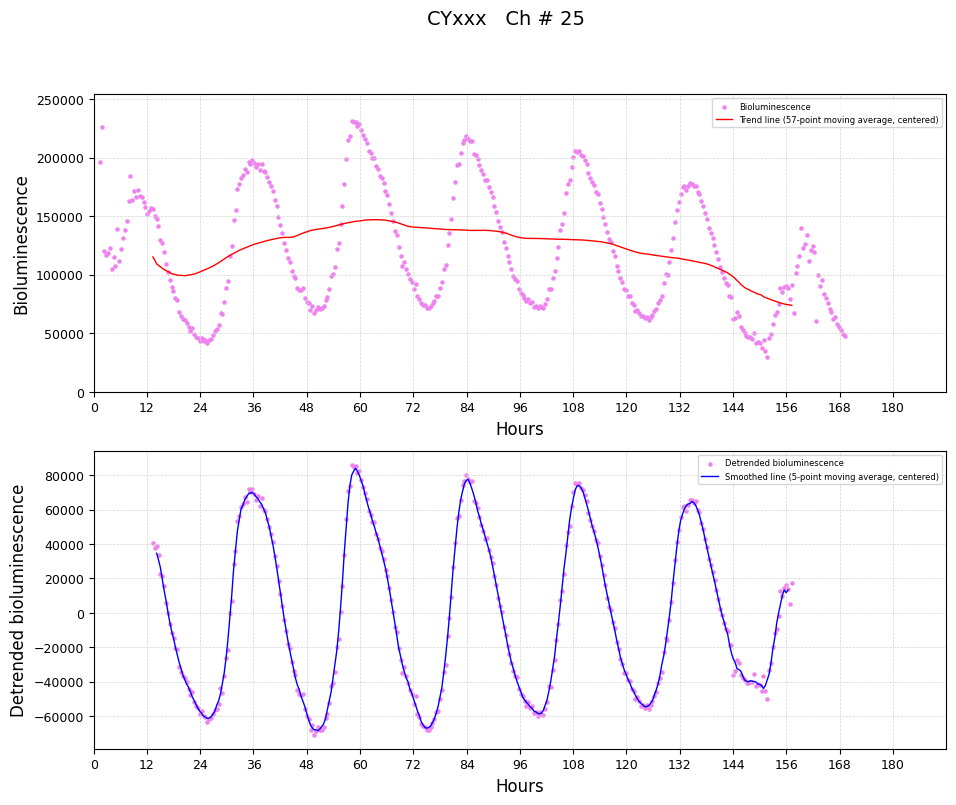

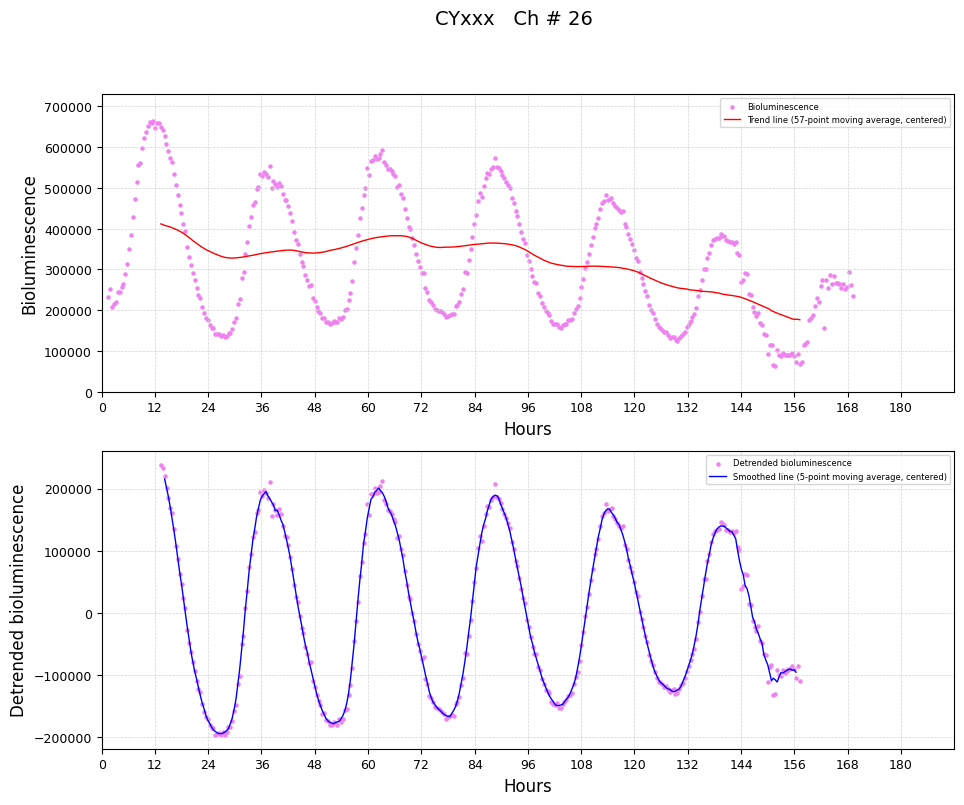

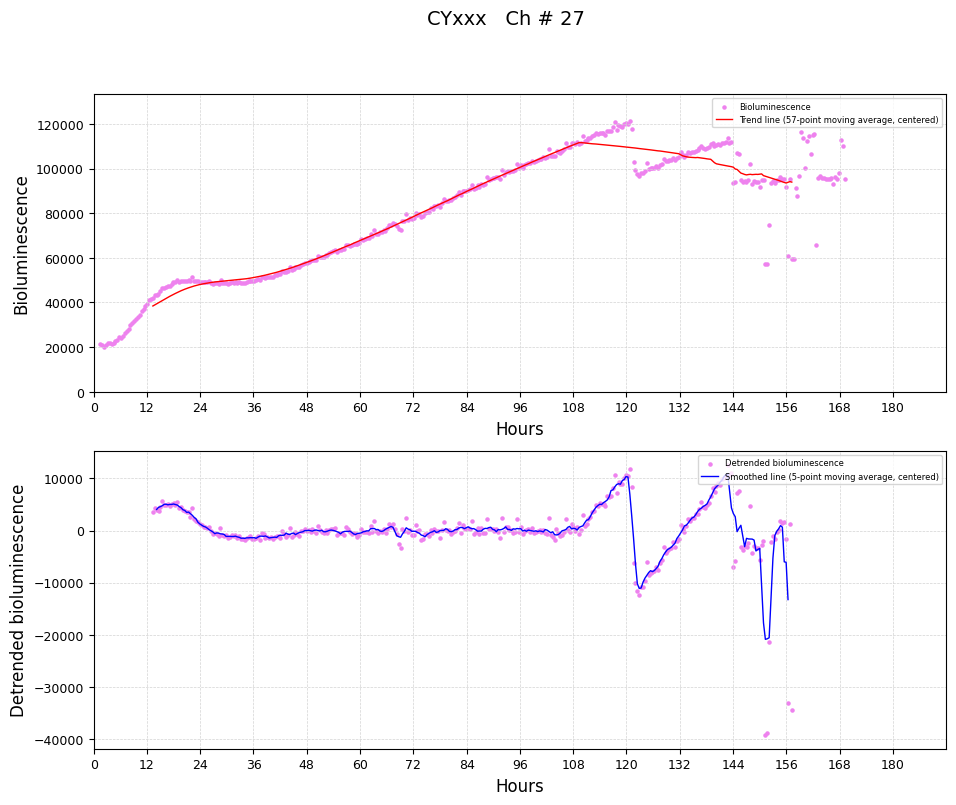

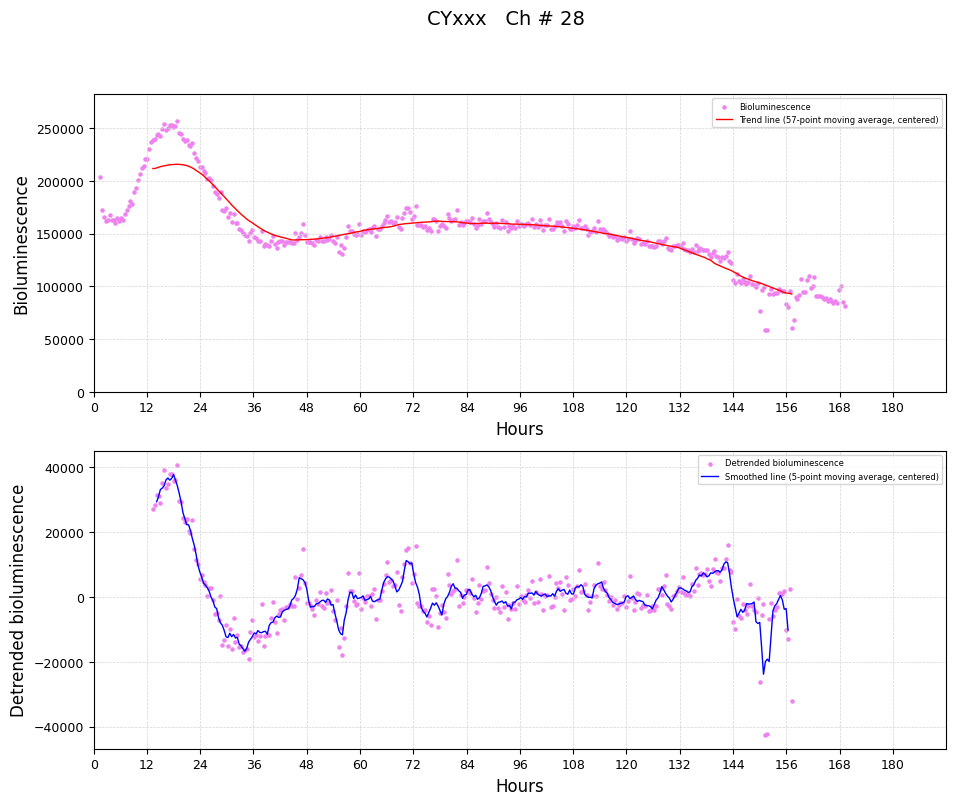

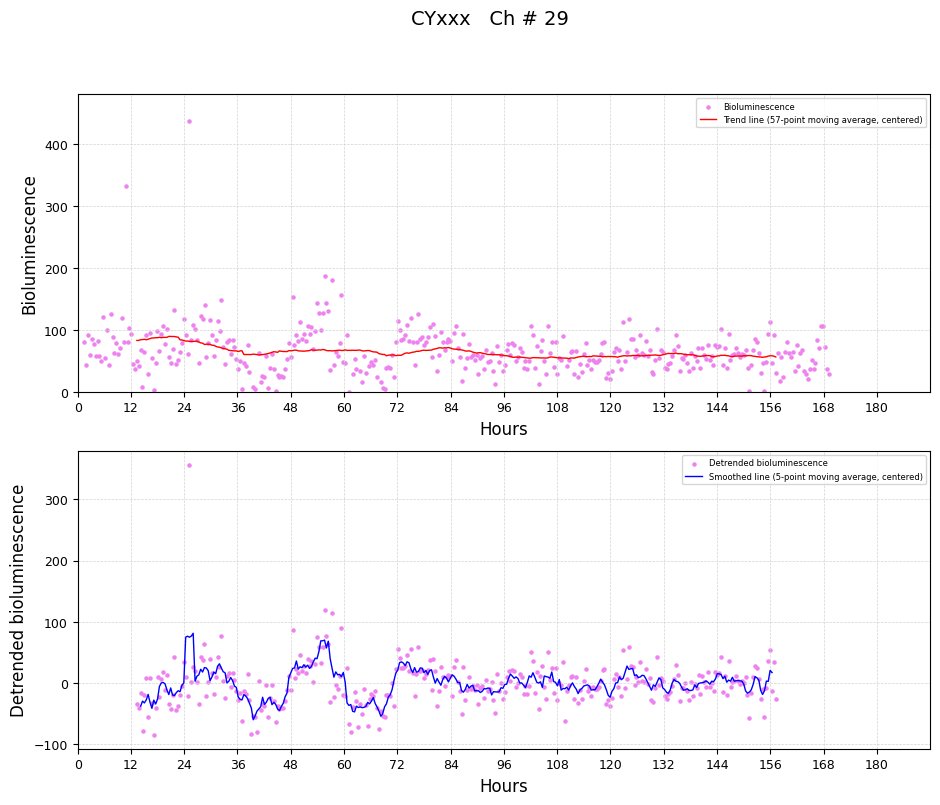

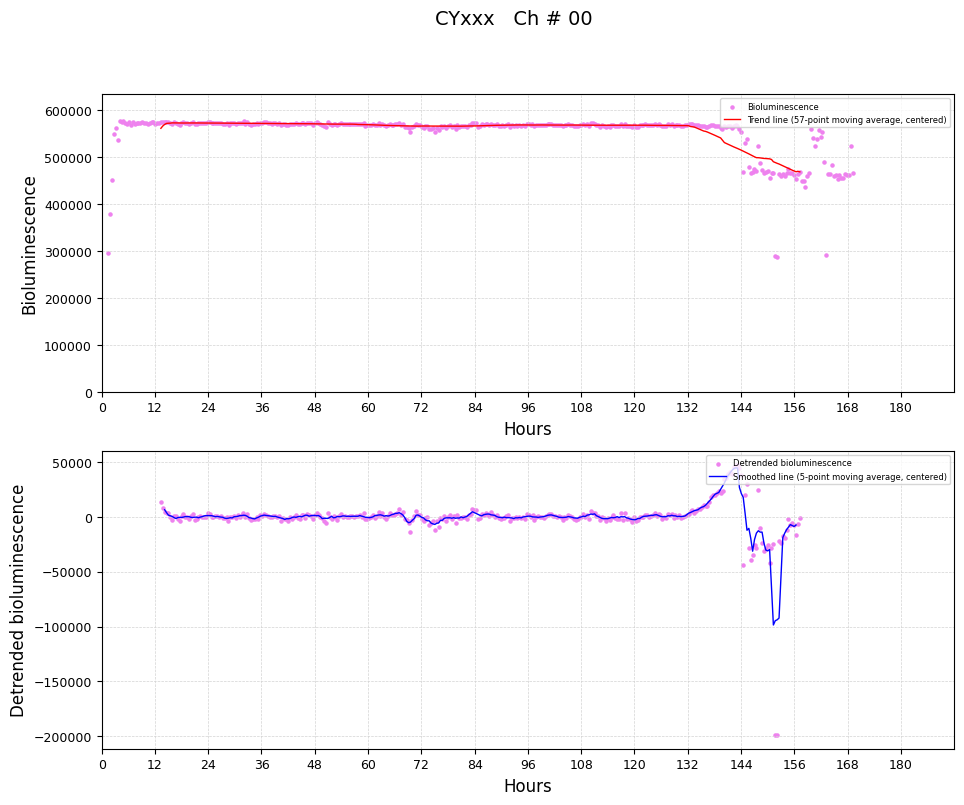

In [2]:
#@title Converting Ttron TRACES file (TRACES.nnn) to Excel file
#
# This is a simple script for coverting a Taylortron data file (the Johnson
# Lab, 30 channels, "TRACES.nnn" file) to an Excel file, detrending, smoothing,
# and plotting the data.
# by dxda6216 (Email: dxda6216 AT gmail DOT com)
#
import pandas as pd
import csv
import math
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
import io
from google.colab import files

#@markdown **This script works only with a specific format of data files (*TRACES.nnn* files) generated by the Taylortron in the Johnson Lab.**
#@markdown - [GitHub repository page](https://github.com/dxda6216/ttron2excel)
Experiment_number = 'CYxxx' #@param {type:"string"}
Experiment_title = '' #@param {type:"string"}
Date_experiment_started = '2020-01-01' #@param {type:"date"}

Data_plotting = "Plotting the channel 00 data last" #@param ["Plotting the channel 00 data first", "Plotting the channel 00 data last"]

# Plotting the data from the channel 0 or from the channel 1
if Data_plotting == "Plotting the channel 00 data first":
	chlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
else:
	chlist = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,0]

#@markdown 1. Input the experiment number (avoid spaces and special characters).
#@markdown 2. Input the experiment title (this field can be blank).
#@markdown 3. Input the date on which the experiment started (in *YYYY/MM/DD* format).
#@markdown 4. **Runtime** -> **Restart and run all** (or press **Ctrl+M** and then press **Ctrl+F9**)
#@markdown 5. Wait until `Choose Files` or `Browse...` button appears below.
#@markdown 6. Click `Choose Files` or `Browse...` button and select *TRACES.nnn* file in your computer.
#@markdown 7. Wait a while. Two Excel files, one ZIP file, and one PDF file will be saved in "Downloads" folder in your computer.

#@markdown - The first Excel file will have multiple spreadsheets, conatining all the raw data, smoothed data, and detranded data.
#@markdown - The second Excel file will have a single spreadsheet, conatining only the raw time series data without measurement time information. The interval time will be indicated as a sheet name of the Excel spreadsheet. This file can be opened with data analysis programs such as [pyBOAT](https://github.com/tensionhead/pyBOAT).
#@markdown - The ZIP file will contain separate data files (.dat files) for each of the channels. The .dat files can be opened with the [LumiCycle](https://actimetrics.com/products/lumicycle/) Analysis program.

### Deleting old data files
!rm -r -f *.xlsx *.pdf *.dat *.zip TRACES.* Traces.* traces.*

### Uploading TRACES.xxx file
uploaded = files.upload()
ttronfilename = next(iter(uploaded))

### Reading the uploaded TRACES file to a dataframe
print('\nReading the data...')

colnames = ["Hours","00","01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29"]

df = pd.read_csv(ttronfilename, header=None, sep ='\t', skiprows=3, skipfooter=1, index_col=False, names=colnames, engine='python')
df2= df.iloc[:,1:31]

print(df)
print(df2)

number_of_rows = len(df.index)
last_row_index = number_of_rows - 1
print('Number of rows: ' + str(number_of_rows))
print('First time points: ' + str(df.loc[0]['Hours']) + ' h')
print('Last time points: ' + str(df.loc[last_row_index]['Hours']) + ' h')
total_time = df.loc[last_row_index]['Hours'] - df.loc[0]['Hours']
total_time_in_days = total_time * (1/24)
print('Total time duration: ' + str(total_time) + ' h = ' + str(total_time_in_days) + ' days')
time_interval = total_time / last_row_index
excel2_sheet_name = 'INTVL = '+str('{:.15f}'.format(time_interval))+' h'
print('Average time interval: ' + str(time_interval) + ' h')

###### Moving average time window for trend line
###### Setting to 24~ hours
tws = math.ceil(24/time_interval)
if tws%2 == 0:
	tws = tws + 1

twss = int(tws)
twst = time_interval * twss
print('\nWindow size for trend line: ' + str(twss) + ' points')
print('Window size for trend line: ' + str('{:.6f}'.format(twst)) + ' h')

####### Calculating moving averages
print('\nCalculating moving averages...')
df_5PMA = df.rolling(window=5, center=True).mean()
df_9PMA = df.rolling(window=9, center=True).mean()
df_TL_MA = df.rolling(window=twss, center=True).mean()
dtdf = df - df_TL_MA
dtdf['Hours'] = df_TL_MA['Hours']
dtdf_5PMA = dtdf.rolling(window=5, center=True).mean()
dtdf_9PMA = dtdf.rolling(window=9, center=True).mean()

### Generating an Excel file containing all the data
print('\nGenerating an Excel file...')
now = datetime.now(timezone.utc)
processed_dnt_str = now.strftime("%Y-%m-%d %H:%M:%S")
note_df = pd.DataFrame.from_dict(
	{
		'A': ['Experiment Number', 'Experiment Title', 'Experiment Start Date', 'TRACES File', '', 'Number of Time Points', 'Total Time Duration (Hours)', 'Average Time Interval (Hours)', '', 'Data Processed Date and Time (UTC)'],
		'B': ['', '', '', '', '', '', '', '', '', ''],
		'C': ['', '', '', '', '', '', '', '', '', ''],
		'D': ['', '', '', '', '', '', '', '', '', ''],
		'E': [Experiment_number, Experiment_title, Date_experiment_started, ttronfilename, '', number_of_rows, total_time, time_interval, '', processed_dnt_str]
	}
)
trendline_sheet_name = 'Trend line ('+str(twss)+'PMA)'
outputexcelfilename = Experiment_number+"_data.xlsx"
with pd.ExcelWriter(outputexcelfilename) as writer:
	note_df.to_excel(writer, sheet_name='Note', index=None, header=False)
	df.to_excel(writer, sheet_name='Raw Data')
	df_5PMA.to_excel(writer, sheet_name='5-point moving average (5PMA)')
	df_9PMA.to_excel(writer, sheet_name='9-point moving average (9PMA)')
	df_TL_MA.to_excel(writer, sheet_name=trendline_sheet_name)
	dtdf.to_excel(writer, sheet_name='Detrended Data')
	dtdf_5PMA.to_excel(writer, sheet_name='Detrended Data 5PMA')
	dtdf_9PMA.to_excel(writer, sheet_name='Detrended Data 9PMA')
	for k in range(0, 30, 1):
		channelnumber = str(k).zfill(2)
		chnum = 'Channel '+channelnumber
		dfx = pd.DataFrame()
		dfx['Hours'] = df['Hours']
		dfx['Raw_data'] = df[channelnumber]
		dfx['5PMA'] = df_5PMA[channelnumber]
		dfx['9PMA'] = df_9PMA[channelnumber]
		dfx['trend_line'] = df_TL_MA[channelnumber]
		dfx['detrended_data'] = dtdf[channelnumber]
		dfx['detrended_data_5PMA'] = dtdf_5PMA[channelnumber]
		dfx['detrended_data_9MPA'] = dtdf_9PMA[channelnumber]
		dfx.to_excel(writer, sheet_name=chnum)

print('\nExcel file: '+outputexcelfilename+'  has been generated.')

### Generating an Excel file conatining only the raw data without 'Hours'
outputexcelfilename2 = Experiment_number+"_data_2.xlsx"
with pd.ExcelWriter(outputexcelfilename2) as writer:
	df2.to_excel(writer, sheet_name=excel2_sheet_name, index=None, header=True)

print('\nExcel file: '+outputexcelfilename2+'  has been generated.')

### Generating .dat files
print('\nGenerating a data file for each channel (.dat files)...')
df['Days'] = df['Hours'] / 24.000
for k in range(0, 30, 1):
	channelnumber = str(k).zfill(2)
	datfilename = channelnumber + '.dat'
	df.to_csv(datfilename, header=False, index=False, sep ='\t', columns=['Days',channelnumber])

### Packing all the .dat files into a zip file
print('\nPacking .dat files into a zip file...')
zip_output_filename = Experiment_number + '_data.zip'
!zip -r {zip_output_filename} ./*.dat

print('\nPlotting...')
plot_output_pdf = Experiment_number + "_data_plots.pdf"
x = df['Hours']
x_scale_min = int(math.floor(min(x)*(1/24)))*24
x_scale_max = int(math.ceil(max(x)*(1/12)))*12+12
xtickslist = list(range(x_scale_min, x_scale_max, 12))

pp = PdfPages(plot_output_pdf)
plt.rcParams.update({'figure.max_open_warning': 0})

fig = plt.figure(figsize=(11, 8.5))
fig.subplots_adjust(hspace=0.15)

plt.rc('font', size=5)
plt.rc('axes', titlesize=4)
plt.rc('axes', labelsize=4)
plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)
plt.rc('legend', fontsize=3)
plt.rc('figure', titlesize=5)

subplotnumber = 1
for k in chlist:
		channelnumber = str(k).zfill(2)
		plt.subplot(10, 3, subplotnumber)
		x = df['Hours']
		y = df[channelnumber]
		x_cma = df_TL_MA['Hours']
		y_cma = df_TL_MA[channelnumber]

		print('Plotting Channel '+channelnumber)
		chlabel = 'Ch # '+channelnumber
		plt.scatter(x,y,s=0.1,c='blue', label=chlabel)
		plt.plot(x_cma,y_cma,'-r', linewidth=0.5, label='trend line')
		plt.xlim(x_scale_min-6, x_scale_max)
		y_scale_max = int(max(y)*1.100)
		plt.ylim(0, y_scale_max)
		plt.xticks(xtickslist)
		plt.grid(True, linewidth=0.5, color='lightgray', linestyle='--')
		plt.legend(loc='upper right', fontsize=4)
		plt.suptitle(Experiment_number, fontsize=12)
		subplotnumber += 1

fig.text(0.50, 0.08, 'Time (hours)', horizontalalignment='center', fontsize = 10)
fig.text(0.08, 0.50, 'Bioluminescence', horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize = 10)
pp.savefig(fig)

fig = plt.figure(figsize=(11, 8.5))
fig.subplots_adjust(hspace=0.15)

subplotnumber = 1
for k in chlist:
		channelnumber = str(k).zfill(2)
		plt.subplot(10, 3, subplotnumber)
		y = df[channelnumber]
		x_dt = dtdf['Hours']
		y_dt = dtdf[channelnumber]
		x_dt_cma = dtdf_5PMA['Hours']
		y_dt_cma = dtdf_5PMA[channelnumber]
		chlabel = 'Ch # '+channelnumber+' - detrend'
		print('Plotting Channel '+channelnumber+' (detrended)')
		plt.scatter(x_dt,y_dt,s=0.1,c='blue', label=chlabel)
		plt.plot(x_dt_cma,y_dt_cma,'-r', linewidth=0.5)
		plt.xlim(x_scale_min-6, x_scale_max)
		plt.xticks(xtickslist)
		plt.grid(True, linewidth=0.5, color='lightgray', linestyle='--')
		plt.legend(loc='upper right', fontsize=4)
		plt.suptitle(Experiment_number+' - detrended data', fontsize=12)
		subplotnumber += 1

fig.text(0.50, 0.08, 'Time (hours)', horizontalalignment='center', fontsize = 10)
fig.text(0.08, 0.50, 'Detrended Bioluminescence', horizontalalignment='center', verticalalignment='center', rotation='vertical', fontsize = 10)
pp.savefig(fig)

print('\nPlotting...')
x = df['Hours']
x_scale_min = int(math.floor(min(x)*(1/24)))*24
x_scale_max = int(math.ceil(max(x)*(1/12)))*12+12
xtickslist = list(range(x_scale_min, x_scale_max, 12))

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=14)

for k in chlist:
	fig = plt.figure(figsize=(11, 8.5))
	channelnumber = str(k).zfill(2)
	x = df['Hours']
	y = df[channelnumber]
	x_5cma = df_5PMA['Hours']
	y_5cma = df_5PMA[channelnumber]
	print('Plotting Channel '+channelnumber)
	plt.scatter(x,y,s=5.0,c='violet', label='Bioluminescence')
	plt.plot(x_5cma,y_5cma,'-r', linewidth=1.0, label='Smoothed line (5-point moving average, centered)')
	plt.xlim(x_scale_min, x_scale_max)
	y_scale_max = int(max(y)*1.100)
	plt.ylim(0, y_scale_max)
	plt.xticks(np.arange(x_scale_min, x_scale_max, 12.0))
	plt.xlabel('Hours', fontsize=12)
	plt.ylabel('Bioluminescence', fontsize=12)
	plt.grid(True, linewidth=0.5, color='lightgray', linestyle='--')
	plt.legend(loc='upper right', fontsize=6)
	plt.suptitle(Experiment_number+'   Ch # '+channelnumber, fontsize=14)
	pp.savefig(fig)

plt.rc('font', size=10)
plt.rc('axes', titlesize=10)
plt.rc('axes', labelsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('legend', fontsize=6)
plt.rc('figure', titlesize=14)

print('\nPlotting...')

for k in chlist:
	fig = plt.figure(figsize=(11, 8.5))
	channelnumber = str(k).zfill(2)
	x = df['Hours']
	y = df[channelnumber]
	x_cma = df_TL_MA['Hours']
	y_cma = df_TL_MA[channelnumber]
	x_dt = dtdf['Hours']
	y_dt = dtdf[channelnumber]
	x_dt_cma = dtdf_5PMA['Hours']
	y_dt_cma = dtdf_5PMA[channelnumber]

	plt.subplot(2, 1, 1)
	print('Plotting Channel '+channelnumber)
	plt.scatter(x,y,s=5.0,c='violet', label='Bioluminescence')
	plt.plot(x_cma,y_cma,'-r', linewidth=1.0, label='Trend line (' + str(twss) +'-point moving average, centered)')
	plt.xlim(x_scale_min, x_scale_max)
	y_scale_max = int(max(y)*1.100)
	plt.ylim(0, y_scale_max)
	plt.xticks(np.arange(x_scale_min, x_scale_max, 12.0))
	plt.xlabel('Hours', fontsize=12)
	plt.ylabel('Bioluminescence', fontsize=12)
	plt.grid(True, linewidth=0.5, color='lightgray', linestyle='--')
	plt.legend(loc='upper right', fontsize=6)

	plt.subplot(2, 1, 2)
	print('Plotting Channel '+channelnumber+' (detrended)')
	plt.scatter(x_dt,y_dt,s=5.0,c='violet', label='Detrended bioluminescence')
	plt.plot(x_dt_cma,y_dt_cma,'-b', linewidth=1.0, label='Smoothed line (5-point moving average, centered)')
	plt.xlim(x_scale_min, x_scale_max)
	plt.xticks(np.arange(x_scale_min, x_scale_max, 12.0))
	plt.xlabel('Hours', fontsize=12)
	plt.ylabel('Detrended bioluminescence', fontsize=12)
	plt.grid(True, linewidth=0.5, color='lightgray', linestyle='--')
	plt.legend(loc='upper right', fontsize=6)
	plt.suptitle(Experiment_number+'   Ch # '+channelnumber, fontsize=14)
	pp.savefig(fig)

pp.close()

files.download(outputexcelfilename)
files.download(outputexcelfilename2)
files.download(plot_output_pdf)
files.download(zip_output_filename)
